# Data Augmentation

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model
from keras.layers.advanced_activations import PReLU
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset

In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

kf = KFold(n_splits=10, shuffle=True, random_state=48)
epochs = 100
cnn_auc = []
rnn_auc = []

In [4]:
def jitter(x, sigma=0.03):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

In [5]:
def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

In [6]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body Modality (Skeleton)

### 1.1 Apply Data Augmentation

In [7]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(812, 1, 350, 35) (812, 1)
(245, 1, 350, 35) (245, 1)


In [8]:
jitter_X = jitter(X, sigma=0.03)

In [9]:
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [10]:
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((y, y), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(2436, 1, 350, 35)

### 1.2 CNN + BiLSTM

In [13]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(300, activation='tanh'))(flatten)
        dense = Dense(128, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
69/69 - 5s - loss: 0.7375 - accuracy: 0.5151 - auc_1: 0.5210 - precision_1: 0.5224 - recall_1: 0.5229 - f1_score: 0.6735 - val_loss: 0.7171 - val_accuracy: 0.5287 - val_auc_1: 0.5519 - val_precision_1: 0.4706 - val_recall_1: 0.0702 - val_f1_score: 0.6369 - 5s/epoch - 79ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6811 - accuracy: 0.5703 - auc_1: 0.5894 - precision_1: 0.5705 - recall_1: 0.6217 - f1_score: 0.6735 - val_loss: 0.7708 - val_accuracy: 0.5205 - val_auc_1: 0.5699 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6369 - 2s/epoch - 28ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6365 - accuracy: 0.6118 - auc_1: 0.6735 - precision_1: 0.6187 - recall_1: 0.6137 - f1_score: 0.6735 - val_loss: 0.7048 - val_accuracy: 0.5738 - val_auc_1: 0.5861 - val_precision_1: 0.5424 - val_recall_1: 0.5614 - val_f1_score: 0.6369 - 2s/epoch - 29ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5972 - accuracy: 0.6674 - auc_1: 0.7292 - precision_1: 0.6708 - recall_1: 0.6774 - f1_sco

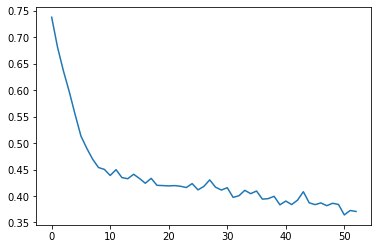

Epoch 1/100
69/69 - 5s - loss: 0.7502 - accuracy: 0.5292 - auc_2: 0.5268 - precision_2: 0.5303 - recall_2: 0.5341 - f1_score: 0.6679 - val_loss: 0.7166 - val_accuracy: 0.5246 - val_auc_2: 0.5708 - val_precision_2: 0.5319 - val_recall_2: 0.7812 - val_f1_score: 0.6882 - 5s/epoch - 77ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6669 - accuracy: 0.5995 - auc_2: 0.6364 - precision_2: 0.6034 - recall_2: 0.5869 - f1_score: 0.6679 - val_loss: 0.6574 - val_accuracy: 0.6107 - val_auc_2: 0.6473 - val_precision_2: 0.6486 - val_recall_2: 0.5625 - val_f1_score: 0.6882 - 2s/epoch - 29ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6343 - accuracy: 0.6492 - auc_2: 0.6928 - precision_2: 0.6497 - recall_2: 0.6515 - f1_score: 0.6679 - val_loss: 0.6696 - val_accuracy: 0.5861 - val_auc_2: 0.6449 - val_precision_2: 0.6174 - val_recall_2: 0.5547 - val_f1_score: 0.6882 - 2s/epoch - 27ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5920 - accuracy: 0.6839 - auc_2: 0.7452 - precision_2: 0.6883 - recall_2: 0.6752 - f1_score: 0.66

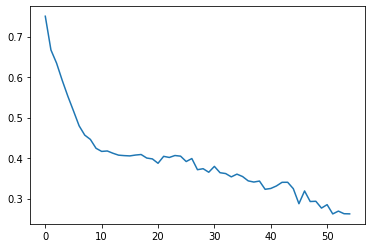

Epoch 1/100
69/69 - 6s - loss: 0.7614 - accuracy: 0.5260 - auc_3: 0.5398 - precision_3: 0.5316 - recall_3: 0.5797 - f1_score: 0.6747 - val_loss: 0.7092 - val_accuracy: 0.4795 - val_auc_3: 0.5951 - val_precision_3: 0.4619 - val_recall_3: 0.8739 - val_f1_score: 0.6254 - 6s/epoch - 80ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6751 - accuracy: 0.5771 - auc_3: 0.6052 - precision_3: 0.5760 - recall_3: 0.6416 - f1_score: 0.6747 - val_loss: 0.6961 - val_accuracy: 0.5615 - val_auc_3: 0.5953 - val_precision_3: 0.5135 - val_recall_3: 0.6847 - val_f1_score: 0.6254 - 2s/epoch - 29ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6302 - accuracy: 0.6391 - auc_3: 0.6908 - precision_3: 0.6376 - recall_3: 0.6747 - f1_score: 0.6747 - val_loss: 0.7028 - val_accuracy: 0.5451 - val_auc_3: 0.6008 - val_precision_3: 0.5000 - val_recall_3: 0.1982 - val_f1_score: 0.6254 - 2s/epoch - 27ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5957 - accuracy: 0.6775 - auc_3: 0.7373 - precision_3: 0.6818 - recall_3: 0.6873 - f1_score: 0.67

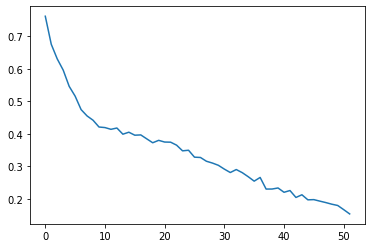

Epoch 1/100
69/69 - 5s - loss: 0.7520 - accuracy: 0.5169 - auc_4: 0.5230 - precision_4: 0.5245 - recall_4: 0.5457 - f1_score: 0.6747 - val_loss: 0.6885 - val_accuracy: 0.5041 - val_auc_4: 0.5626 - val_precision_4: 0.2500 - val_recall_4: 0.0450 - val_f1_score: 0.6254 - 5s/epoch - 77ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6692 - accuracy: 0.5858 - auc_4: 0.6225 - precision_4: 0.5878 - recall_4: 0.6237 - f1_score: 0.6747 - val_loss: 0.7244 - val_accuracy: 0.5205 - val_auc_4: 0.5571 - val_precision_4: 0.4758 - val_recall_4: 0.5315 - val_f1_score: 0.6254 - 2s/epoch - 27ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6393 - accuracy: 0.6186 - auc_4: 0.6712 - precision_4: 0.6224 - recall_4: 0.6380 - f1_score: 0.6747 - val_loss: 0.7514 - val_accuracy: 0.4795 - val_auc_4: 0.5336 - val_precision_4: 0.3519 - val_recall_4: 0.1712 - val_f1_score: 0.6254 - 2s/epoch - 27ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5926 - accuracy: 0.6556 - auc_4: 0.7356 - precision_4: 0.6613 - recall_4: 0.6631 - f1_score: 0.67

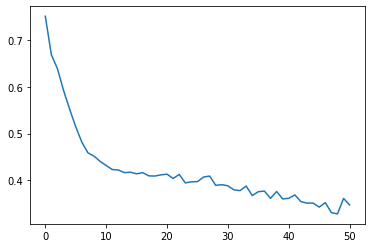

Epoch 1/100
69/69 - 6s - loss: 0.7312 - accuracy: 0.5128 - auc_5: 0.5045 - precision_5: 0.5136 - recall_5: 0.5005 - f1_score: 0.6671 - val_loss: 0.6950 - val_accuracy: 0.5369 - val_auc_5: 0.5867 - val_precision_5: 0.5381 - val_recall_5: 0.9231 - val_f1_score: 0.6952 - 6s/epoch - 80ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6674 - accuracy: 0.5871 - auc_5: 0.6243 - precision_5: 0.5839 - recall_5: 0.6089 - f1_score: 0.6671 - val_loss: 0.7206 - val_accuracy: 0.5697 - val_auc_5: 0.6022 - val_precision_5: 0.6623 - val_recall_5: 0.3923 - val_f1_score: 0.6952 - 2s/epoch - 27ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6306 - accuracy: 0.6236 - auc_5: 0.6863 - precision_5: 0.6241 - recall_5: 0.6235 - f1_score: 0.6671 - val_loss: 0.7028 - val_accuracy: 0.5738 - val_auc_5: 0.5961 - val_precision_5: 0.6182 - val_recall_5: 0.5231 - val_f1_score: 0.6952 - 2s/epoch - 27ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5801 - accuracy: 0.6784 - auc_5: 0.7538 - precision_5: 0.6747 - recall_5: 0.6901 - f1_score: 0.66

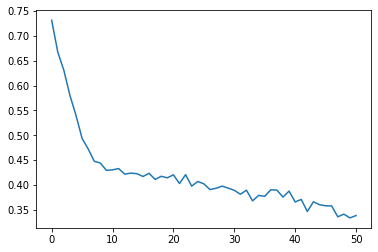

Epoch 1/100
69/69 - 6s - loss: 0.7869 - accuracy: 0.5201 - auc_6: 0.5294 - precision_6: 0.5231 - recall_6: 0.5439 - f1_score: 0.6703 - val_loss: 0.6884 - val_accuracy: 0.5123 - val_auc_6: 0.6168 - val_precision_6: 0.5319 - val_recall_6: 0.2049 - val_f1_score: 0.6667 - 6s/epoch - 80ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6715 - accuracy: 0.5821 - auc_6: 0.6168 - precision_6: 0.5873 - recall_6: 0.5756 - f1_score: 0.6703 - val_loss: 0.6693 - val_accuracy: 0.6434 - val_auc_6: 0.6624 - val_precision_6: 0.6336 - val_recall_6: 0.6803 - val_f1_score: 0.6667 - 2s/epoch - 29ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6326 - accuracy: 0.6300 - auc_6: 0.6851 - precision_6: 0.6344 - recall_6: 0.6281 - f1_score: 0.6703 - val_loss: 0.6528 - val_accuracy: 0.6270 - val_auc_6: 0.6746 - val_precision_6: 0.6372 - val_recall_6: 0.5902 - val_f1_score: 0.6667 - 2s/epoch - 29ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5928 - accuracy: 0.6697 - auc_6: 0.7333 - precision_6: 0.6782 - recall_6: 0.6561 - f1_score: 0.67

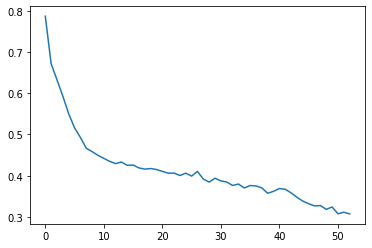

Epoch 1/100
69/69 - 5s - loss: 0.7728 - accuracy: 0.5116 - auc_7: 0.5097 - precision_7: 0.5110 - recall_7: 0.5087 - f1_score: 0.6661 - val_loss: 0.6845 - val_accuracy: 0.5802 - val_auc_7: 0.5950 - val_precision_7: 0.6705 - val_recall_7: 0.4470 - val_f1_score: 0.7040 - 5s/epoch - 77ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6728 - accuracy: 0.5946 - auc_7: 0.6184 - precision_7: 0.5936 - recall_7: 0.5963 - f1_score: 0.6661 - val_loss: 0.6878 - val_accuracy: 0.5597 - val_auc_7: 0.5998 - val_precision_7: 0.5698 - val_recall_7: 0.7727 - val_f1_score: 0.7040 - 2s/epoch - 27ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6357 - accuracy: 0.6357 - auc_7: 0.6851 - precision_7: 0.6355 - recall_7: 0.6338 - f1_score: 0.6661 - val_loss: 0.6960 - val_accuracy: 0.5926 - val_auc_7: 0.5904 - val_precision_7: 0.6000 - val_recall_7: 0.7500 - val_f1_score: 0.7040 - 2s/epoch - 27ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5923 - accuracy: 0.6826 - auc_7: 0.7453 - precision_7: 0.6796 - recall_7: 0.6895 - f1_score: 0.66

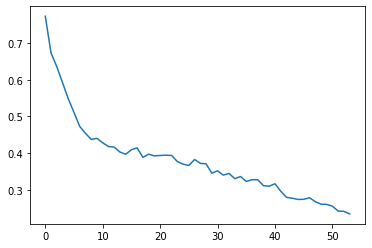

Epoch 1/100
69/69 - 6s - loss: 0.7541 - accuracy: 0.4838 - auc_8: 0.4786 - precision_8: 0.4798 - recall_8: 0.4009 - f1_score: 0.6661 - val_loss: 0.7537 - val_accuracy: 0.4650 - val_auc_8: 0.5463 - val_precision_8: 0.5833 - val_recall_8: 0.0530 - val_f1_score: 0.7040 - 6s/epoch - 82ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6864 - accuracy: 0.5344 - auc_8: 0.5569 - precision_8: 0.5352 - recall_8: 0.5142 - f1_score: 0.6661 - val_loss: 0.6996 - val_accuracy: 0.4979 - val_auc_8: 0.5567 - val_precision_8: 0.5962 - val_recall_8: 0.2348 - val_f1_score: 0.7040 - 2s/epoch - 29ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6504 - accuracy: 0.5768 - auc_8: 0.6293 - precision_8: 0.5777 - recall_8: 0.5671 - f1_score: 0.6661 - val_loss: 0.7508 - val_accuracy: 0.5432 - val_auc_8: 0.4941 - val_precision_8: 0.5443 - val_recall_8: 0.9773 - val_f1_score: 0.7040 - 2s/epoch - 28ms/step
Epoch 4/100
69/69 - 2s - loss: 0.6249 - accuracy: 0.5905 - auc_8: 0.6565 - precision_8: 0.5895 - recall_8: 0.5927 - f1_score: 0.66

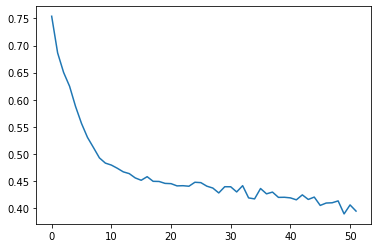

Epoch 1/100
69/69 - 5s - loss: 0.7537 - accuracy: 0.5084 - auc_9: 0.5190 - precision_9: 0.5115 - recall_9: 0.5023 - f1_score: 0.6693 - val_loss: 0.6973 - val_accuracy: 0.5432 - val_auc_9: 0.5605 - val_precision_9: 0.5344 - val_recall_9: 0.8145 - val_f1_score: 0.6757 - 5s/epoch - 72ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6704 - accuracy: 0.5768 - auc_9: 0.6163 - precision_9: 0.5772 - recall_9: 0.5929 - f1_score: 0.6693 - val_loss: 0.6966 - val_accuracy: 0.5432 - val_auc_9: 0.5931 - val_precision_9: 0.5468 - val_recall_9: 0.6129 - val_f1_score: 0.6757 - 2s/epoch - 26ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6304 - accuracy: 0.6306 - auc_9: 0.6863 - precision_9: 0.6238 - recall_9: 0.6691 - f1_score: 0.6693 - val_loss: 0.7071 - val_accuracy: 0.5926 - val_auc_9: 0.6441 - val_precision_9: 0.6761 - val_recall_9: 0.3871 - val_f1_score: 0.6757 - 2s/epoch - 25ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5974 - accuracy: 0.6644 - auc_9: 0.7297 - precision_9: 0.6661 - recall_9: 0.6673 - f1_score: 0.66

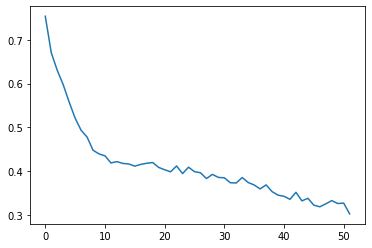

Epoch 1/100
69/69 - 5s - loss: 0.7357 - accuracy: 0.4961 - auc_10: 0.4982 - precision_10: 0.4995 - recall_10: 0.5018 - f1_score: 0.6697 - val_loss: 0.7085 - val_accuracy: 0.5267 - val_auc_10: 0.5484 - val_precision_10: 0.5182 - val_recall_10: 0.9268 - val_f1_score: 0.6721 - 5s/epoch - 77ms/step
Epoch 2/100
69/69 - 2s - loss: 0.6703 - accuracy: 0.5645 - auc_10: 0.6110 - precision_10: 0.5645 - recall_10: 0.5906 - f1_score: 0.6697 - val_loss: 0.7242 - val_accuracy: 0.5802 - val_auc_10: 0.5666 - val_precision_10: 0.5827 - val_recall_10: 0.6016 - val_f1_score: 0.6721 - 2s/epoch - 25ms/step
Epoch 3/100
69/69 - 2s - loss: 0.6289 - accuracy: 0.6270 - auc_10: 0.6850 - precision_10: 0.6198 - recall_10: 0.6703 - f1_score: 0.6697 - val_loss: 0.7088 - val_accuracy: 0.5679 - val_auc_10: 0.5606 - val_precision_10: 0.5738 - val_recall_10: 0.5691 - val_f1_score: 0.6721 - 2s/epoch - 25ms/step
Epoch 4/100
69/69 - 2s - loss: 0.5904 - accuracy: 0.6544 - auc_10: 0.7299 - precision_10: 0.6623 - recall_10: 0.

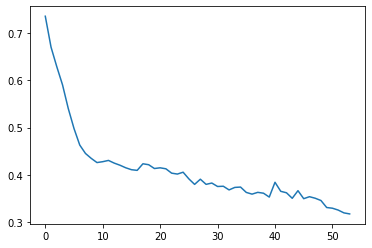

In [14]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        cnnlstm_binary_body_model.save(model_path / 'body_binary_cnnlstm.h5')

#### Predictions on the holdout set

In [15]:
cnnlstm_binary_body_model = load_model(model_path / 'body_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 12ms/step - loss: 0.6317 - accuracy: 0.6898 - auc_3: 0.7025 - precision_3: 0.8963 - recall_3: 0.7136 - f1_score: 0.9135
Accuracy: 68.98% 
ROC/AUC: 0.70 
Precision: 0.90 
Recall: 0.71 
F1 score: 0.91


### 1.2 RCNN

In [16]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(128, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
88/88 - 2s - loss: 0.9996 - accuracy: 0.5488 - auc_11: 0.5519 - precision_11: 0.5538 - recall_11: 0.5732 - f1_score: 0.6735 - val_loss: 1.1331 - val_accuracy: 0.5533 - val_auc_11: 0.5942 - val_precision_11: 0.5132 - val_recall_11: 0.8509 - val_f1_score: 0.6369 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.8722 - accuracy: 0.5817 - auc_11: 0.6032 - precision_11: 0.5833 - recall_11: 0.6164 - f1_score: 0.6735 - val_loss: 0.8918 - val_accuracy: 0.5164 - val_auc_11: 0.5908 - val_precision_11: 0.4884 - val_recall_11: 0.7368 - val_f1_score: 0.6369 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7652 - accuracy: 0.6168 - auc_11: 0.6414 - precision_11: 0.6180 - recall_11: 0.6424 - f1_score: 0.6735 - val_loss: 1.0426 - val_accuracy: 0.5943 - val_auc_11: 0.5987 - val_precision_11: 0.5773 - val_recall_11: 0.4912 - val_f1_score: 0.6369 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.8097 - accuracy: 0.6122 - auc_11: 0.6385 - precision_11: 0.6137 - recall_11: 0.

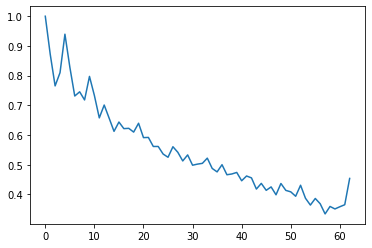

Epoch 1/100
88/88 - 2s - loss: 0.9242 - accuracy: 0.5593 - auc_12: 0.5709 - precision_12: 0.5587 - recall_12: 0.5760 - f1_score: 0.6679 - val_loss: 1.2055 - val_accuracy: 0.5246 - val_auc_12: 0.5829 - val_precision_12: 0.5263 - val_recall_12: 0.9375 - val_f1_score: 0.6882 - 2s/epoch - 27ms/step
Epoch 2/100
88/88 - 1s - loss: 0.7928 - accuracy: 0.5949 - auc_12: 0.6126 - precision_12: 0.5930 - recall_12: 0.6124 - f1_score: 0.6679 - val_loss: 0.9057 - val_accuracy: 0.5533 - val_auc_12: 0.6569 - val_precision_12: 0.5438 - val_recall_12: 0.9219 - val_f1_score: 0.6882 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.8315 - accuracy: 0.5976 - auc_12: 0.6257 - precision_12: 0.5970 - recall_12: 0.6078 - f1_score: 0.6679 - val_loss: 0.8994 - val_accuracy: 0.5943 - val_auc_12: 0.6032 - val_precision_12: 0.6014 - val_recall_12: 0.6719 - val_f1_score: 0.6882 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.8012 - accuracy: 0.6031 - auc_12: 0.6340 - precision_12: 0.6020 - recall_12: 0.

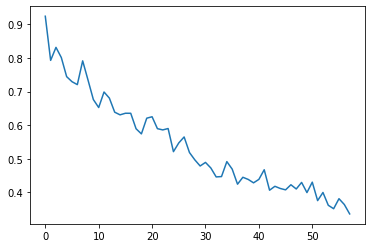

Epoch 1/100
88/88 - 2s - loss: 0.9639 - accuracy: 0.5698 - auc_13: 0.5755 - precision_13: 0.5744 - recall_13: 0.5986 - f1_score: 0.6747 - val_loss: 0.8372 - val_accuracy: 0.5205 - val_auc_13: 0.6191 - val_precision_13: 0.4817 - val_recall_13: 0.7117 - val_f1_score: 0.6254 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.7609 - accuracy: 0.6036 - auc_13: 0.6272 - precision_13: 0.6092 - recall_13: 0.6174 - f1_score: 0.6747 - val_loss: 1.0620 - val_accuracy: 0.5369 - val_auc_13: 0.5740 - val_precision_13: 0.4934 - val_recall_13: 0.6757 - val_f1_score: 0.6254 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7685 - accuracy: 0.6090 - auc_13: 0.6358 - precision_13: 0.6113 - recall_13: 0.6371 - f1_score: 0.6747 - val_loss: 1.0027 - val_accuracy: 0.5779 - val_auc_13: 0.5733 - val_precision_13: 0.5323 - val_recall_13: 0.5946 - val_f1_score: 0.6254 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7561 - accuracy: 0.6286 - auc_13: 0.6649 - precision_13: 0.6299 - recall_13: 0.

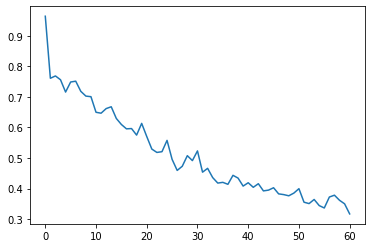

Epoch 1/100
88/88 - 2s - loss: 1.0648 - accuracy: 0.5547 - auc_14: 0.5668 - precision_14: 0.5591 - recall_14: 0.5932 - f1_score: 0.6747 - val_loss: 1.3090 - val_accuracy: 0.5246 - val_auc_14: 0.5097 - val_precision_14: 0.3077 - val_recall_14: 0.0360 - val_f1_score: 0.6254 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.8228 - accuracy: 0.5940 - auc_14: 0.6045 - precision_14: 0.5989 - recall_14: 0.6129 - f1_score: 0.6747 - val_loss: 1.1374 - val_accuracy: 0.5820 - val_auc_14: 0.5759 - val_precision_14: 0.5236 - val_recall_14: 0.9009 - val_f1_score: 0.6254 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.8175 - accuracy: 0.5949 - auc_14: 0.6145 - precision_14: 0.5991 - recall_14: 0.6174 - f1_score: 0.6747 - val_loss: 0.7710 - val_accuracy: 0.6393 - val_auc_14: 0.6287 - val_precision_14: 0.5852 - val_recall_14: 0.7117 - val_f1_score: 0.6254 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7520 - accuracy: 0.6191 - auc_14: 0.6483 - precision_14: 0.6253 - recall_14: 0.

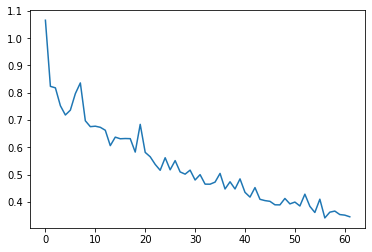

Epoch 1/100
88/88 - 2s - loss: 0.9904 - accuracy: 0.5643 - auc_15: 0.5826 - precision_15: 0.5606 - recall_15: 0.5989 - f1_score: 0.6671 - val_loss: 0.9149 - val_accuracy: 0.5205 - val_auc_15: 0.5201 - val_precision_15: 0.5890 - val_recall_15: 0.3308 - val_f1_score: 0.6952 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.7532 - accuracy: 0.5995 - auc_15: 0.6238 - precision_15: 0.5977 - recall_15: 0.6108 - f1_score: 0.6671 - val_loss: 0.9116 - val_accuracy: 0.5492 - val_auc_15: 0.5779 - val_precision_15: 0.5463 - val_recall_15: 0.9077 - val_f1_score: 0.6952 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7907 - accuracy: 0.6109 - auc_15: 0.6322 - precision_15: 0.6117 - recall_15: 0.6089 - f1_score: 0.6671 - val_loss: 0.8002 - val_accuracy: 0.5861 - val_auc_15: 0.6362 - val_precision_15: 0.5767 - val_recall_15: 0.8385 - val_f1_score: 0.6952 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.8063 - accuracy: 0.6095 - auc_15: 0.6465 - precision_15: 0.6065 - recall_15: 0.

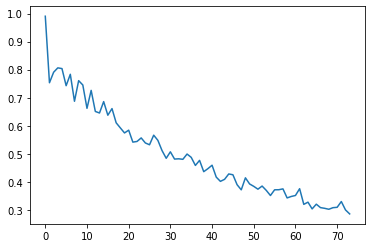

Epoch 1/100
88/88 - 3s - loss: 1.0183 - accuracy: 0.5652 - auc_16: 0.5747 - precision_16: 0.5676 - recall_16: 0.5774 - f1_score: 0.6703 - val_loss: 1.3812 - val_accuracy: 0.5369 - val_auc_16: 0.6534 - val_precision_16: 0.5193 - val_recall_16: 0.9918 - val_f1_score: 0.6667 - 3s/epoch - 29ms/step
Epoch 2/100
88/88 - 1s - loss: 0.7939 - accuracy: 0.5999 - auc_16: 0.6154 - precision_16: 0.5976 - recall_16: 0.6317 - f1_score: 0.6703 - val_loss: 0.8887 - val_accuracy: 0.5902 - val_auc_16: 0.6261 - val_precision_16: 0.5764 - val_recall_16: 0.6803 - val_f1_score: 0.6667 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7951 - accuracy: 0.5922 - auc_16: 0.6163 - precision_16: 0.5921 - recall_16: 0.6136 - f1_score: 0.6703 - val_loss: 0.7680 - val_accuracy: 0.6066 - val_auc_16: 0.6466 - val_precision_16: 0.6327 - val_recall_16: 0.5082 - val_f1_score: 0.6667 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.8317 - accuracy: 0.6118 - auc_16: 0.6393 - precision_16: 0.6134 - recall_16: 0.

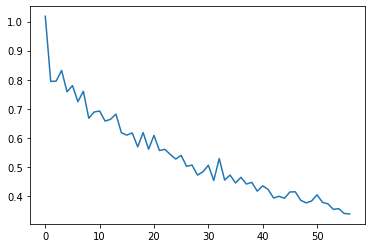

Epoch 1/100
88/88 - 2s - loss: 1.0693 - accuracy: 0.5577 - auc_17: 0.5659 - precision_17: 0.5571 - recall_17: 0.5571 - f1_score: 0.6661 - val_loss: 1.0266 - val_accuracy: 0.5514 - val_auc_17: 0.6199 - val_precision_17: 0.7018 - val_recall_17: 0.3030 - val_f1_score: 0.7040 - 2s/epoch - 25ms/step
Epoch 2/100
88/88 - 1s - loss: 0.9206 - accuracy: 0.5755 - auc_17: 0.5767 - precision_17: 0.5732 - recall_17: 0.5863 - f1_score: 0.6661 - val_loss: 0.8581 - val_accuracy: 0.6008 - val_auc_17: 0.6417 - val_precision_17: 0.6036 - val_recall_17: 0.7727 - val_f1_score: 0.7040 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7935 - accuracy: 0.6037 - auc_17: 0.6239 - precision_17: 0.6027 - recall_17: 0.6055 - f1_score: 0.6661 - val_loss: 0.7946 - val_accuracy: 0.6296 - val_auc_17: 0.6678 - val_precision_17: 0.6364 - val_recall_17: 0.7424 - val_f1_score: 0.7040 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7700 - accuracy: 0.6147 - auc_17: 0.6388 - precision_17: 0.6132 - recall_17: 0.

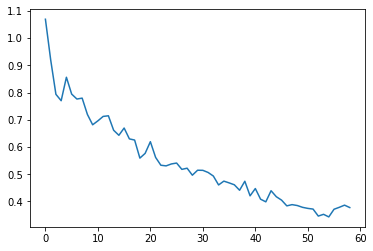

Epoch 1/100
88/88 - 2s - loss: 1.1404 - accuracy: 0.5650 - auc_18: 0.5691 - precision_18: 0.5607 - recall_18: 0.5945 - f1_score: 0.6663 - val_loss: 0.8260 - val_accuracy: 0.5720 - val_auc_18: 0.5971 - val_precision_18: 0.6207 - val_recall_18: 0.5455 - val_f1_score: 0.7040 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.8150 - accuracy: 0.5750 - auc_18: 0.5859 - precision_18: 0.5727 - recall_18: 0.5863 - f1_score: 0.6661 - val_loss: 0.8061 - val_accuracy: 0.5802 - val_auc_18: 0.6464 - val_precision_18: 0.5843 - val_recall_18: 0.7879 - val_f1_score: 0.7040 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7921 - accuracy: 0.5896 - auc_18: 0.6107 - precision_18: 0.5865 - recall_18: 0.6037 - f1_score: 0.6661 - val_loss: 0.6473 - val_accuracy: 0.6543 - val_auc_18: 0.7076 - val_precision_18: 0.6519 - val_recall_18: 0.7803 - val_f1_score: 0.7040 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7767 - accuracy: 0.6147 - auc_18: 0.6291 - precision_18: 0.6126 - recall_18: 0.

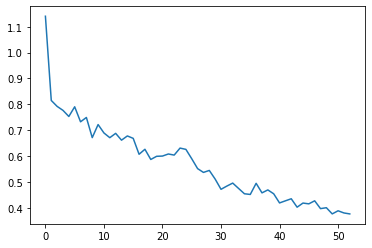

Epoch 1/100
88/88 - 2s - loss: 1.0120 - accuracy: 0.5591 - auc_19: 0.5651 - precision_19: 0.5570 - recall_19: 0.6029 - f1_score: 0.6693 - val_loss: 0.7949 - val_accuracy: 0.6049 - val_auc_19: 0.6174 - val_precision_19: 0.5875 - val_recall_19: 0.7581 - val_f1_score: 0.6757 - 2s/epoch - 26ms/step
Epoch 2/100
88/88 - 1s - loss: 0.7553 - accuracy: 0.5978 - auc_19: 0.6240 - precision_19: 0.5972 - recall_19: 0.6156 - f1_score: 0.6693 - val_loss: 0.7404 - val_accuracy: 0.6379 - val_auc_19: 0.6704 - val_precision_19: 0.6071 - val_recall_19: 0.8226 - val_f1_score: 0.6757 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.7861 - accuracy: 0.5974 - auc_19: 0.6341 - precision_19: 0.5968 - recall_19: 0.6147 - f1_score: 0.6693 - val_loss: 1.0140 - val_accuracy: 0.4897 - val_auc_19: 0.5564 - val_precision_19: 0.5000 - val_recall_19: 0.6694 - val_f1_score: 0.6757 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7218 - accuracy: 0.6265 - auc_19: 0.6652 - precision_19: 0.6224 - recall_19: 0.

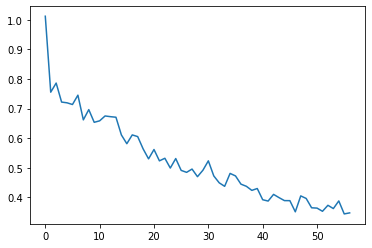

Epoch 1/100
88/88 - 3s - loss: 0.9901 - accuracy: 0.5481 - auc_20: 0.5597 - precision_20: 0.5478 - recall_20: 0.5870 - f1_score: 0.6697 - val_loss: 0.7813 - val_accuracy: 0.5926 - val_auc_20: 0.5843 - val_precision_20: 0.6250 - val_recall_20: 0.4878 - val_f1_score: 0.6721 - 3s/epoch - 29ms/step
Epoch 2/100
88/88 - 1s - loss: 0.8198 - accuracy: 0.5805 - auc_20: 0.6036 - precision_20: 0.5780 - recall_20: 0.6178 - f1_score: 0.6697 - val_loss: 0.7852 - val_accuracy: 0.6049 - val_auc_20: 0.6392 - val_precision_20: 0.5931 - val_recall_20: 0.6992 - val_f1_score: 0.6721 - 1s/epoch - 12ms/step
Epoch 3/100
88/88 - 1s - loss: 0.8443 - accuracy: 0.5768 - auc_20: 0.5971 - precision_20: 0.5779 - recall_20: 0.5915 - f1_score: 0.6697 - val_loss: 0.7339 - val_accuracy: 0.5926 - val_auc_20: 0.6488 - val_precision_20: 0.5952 - val_recall_20: 0.6098 - val_f1_score: 0.6721 - 1s/epoch - 12ms/step
Epoch 4/100
88/88 - 1s - loss: 0.7929 - accuracy: 0.6092 - auc_20: 0.6354 - precision_20: 0.6051 - recall_20: 0.

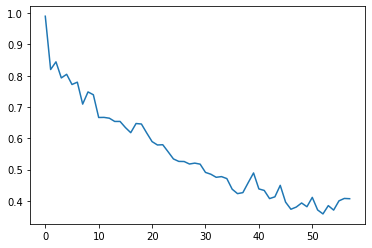

In [17]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=25)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        rcnn_binary_body_model.save(model_path / 'body_binary_rcnn.h5')

In [18]:
rcnn_binary_body_model = load_model(model_path / 'body_binary_rcnn.h5')
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 0.6496 - accuracy: 0.6980 - auc_15: 0.7102 - precision_15: 0.9074 - recall_15: 0.7136 - f1_score: 0.9135
Accuracy: 69.80% 
ROC/AUC: 0.71 
Precision: 0.91 
Recall: 0.71 
F1 score: 0.91


## 2. Unimodal Face Modality (Action units + Head pose)

#### Apply Data Augmentation

In [19]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [20]:
jitter_X = jitter(X, sigma=0.03)

In [21]:
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [22]:
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((y, y), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(2346, 1, 350, 25)

### CNN + BiLSTM

In [23]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(300, activation='tanh'))(flatten)
        dense = Dense(64, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
66/66 - 4s - loss: 0.7203 - accuracy: 0.5533 - auc_21: 0.5601 - precision_21: 0.5537 - recall_21: 0.6080 - f1_score: 0.6723 - val_loss: 0.6557 - val_accuracy: 0.5957 - val_auc_21: 0.6667 - val_precision_21: 0.5778 - val_recall_21: 0.6724 - val_f1_score: 0.6610 - 4s/epoch - 65ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6654 - accuracy: 0.6054 - auc_21: 0.6333 - precision_21: 0.6028 - recall_21: 0.6473 - f1_score: 0.6723 - val_loss: 0.6694 - val_accuracy: 0.5872 - val_auc_21: 0.6432 - val_precision_21: 0.6022 - val_recall_21: 0.4828 - val_f1_score: 0.6610 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6596 - accuracy: 0.6035 - auc_21: 0.6411 - precision_21: 0.6034 - recall_21: 0.6333 - f1_score: 0.6723 - val_loss: 0.6481 - val_accuracy: 0.6170 - val_auc_21: 0.6698 - val_precision_21: 0.5956 - val_recall_21: 0.6983 - val_f1_score: 0.6610 - 1s/epoch - 17ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6547 - accuracy: 0.6087 - auc_21: 0.6499 - precision_21: 0.5995 - recall_21: 0.

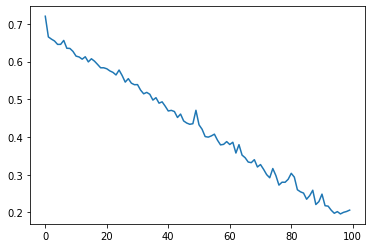

Epoch 1/100
66/66 - 4s - loss: 0.7068 - accuracy: 0.5647 - auc_22: 0.5773 - precision_22: 0.5639 - recall_22: 0.6193 - f1_score: 0.6723 - val_loss: 0.6757 - val_accuracy: 0.5660 - val_auc_22: 0.6009 - val_precision_22: 0.5583 - val_recall_22: 0.5776 - val_f1_score: 0.6610 - 4s/epoch - 65ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6576 - accuracy: 0.6130 - auc_22: 0.6505 - precision_22: 0.6066 - recall_22: 0.6707 - f1_score: 0.6723 - val_loss: 0.6659 - val_accuracy: 0.6298 - val_auc_22: 0.6423 - val_precision_22: 0.6000 - val_recall_22: 0.7500 - val_f1_score: 0.6610 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6503 - accuracy: 0.6158 - auc_22: 0.6644 - precision_22: 0.6114 - recall_22: 0.6623 - f1_score: 0.6723 - val_loss: 0.6617 - val_accuracy: 0.6213 - val_auc_22: 0.6604 - val_precision_22: 0.5957 - val_recall_22: 0.7241 - val_f1_score: 0.6610 - 1s/epoch - 16ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6434 - accuracy: 0.6390 - auc_22: 0.6815 - precision_22: 0.6412 - recall_22: 0.

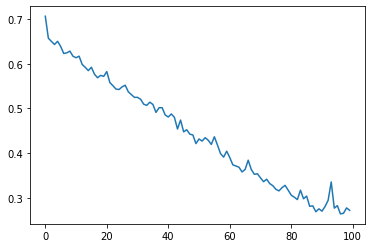

Epoch 1/100
66/66 - 4s - loss: 0.7541 - accuracy: 0.5320 - auc_23: 0.5246 - precision_23: 0.5335 - recall_23: 0.5695 - f1_score: 0.6702 - val_loss: 0.6926 - val_accuracy: 0.5234 - val_auc_23: 0.5698 - val_precision_23: 0.5818 - val_recall_23: 0.2645 - val_f1_score: 0.6798 - 4s/epoch - 63ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6901 - accuracy: 0.5249 - auc_23: 0.5313 - precision_23: 0.5307 - recall_23: 0.4962 - f1_score: 0.6702 - val_loss: 0.6987 - val_accuracy: 0.5064 - val_auc_23: 0.5050 - val_precision_23: 0.5122 - val_recall_23: 0.8678 - val_f1_score: 0.6798 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6909 - accuracy: 0.5296 - auc_23: 0.5411 - precision_23: 0.5317 - recall_23: 0.5592 - f1_score: 0.6702 - val_loss: 0.6981 - val_accuracy: 0.5362 - val_auc_23: 0.5225 - val_precision_23: 0.5280 - val_recall_23: 0.9339 - val_f1_score: 0.6798 - 1s/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6893 - accuracy: 0.5192 - auc_23: 0.5439 - precision_23: 0.5177 - recall_23: 0.

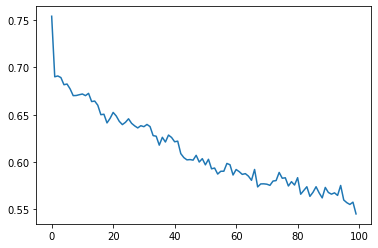

Epoch 1/100
66/66 - 4s - loss: 0.7346 - accuracy: 0.5580 - auc_24: 0.5570 - precision_24: 0.5625 - recall_24: 0.5725 - f1_score: 0.6723 - val_loss: 0.6803 - val_accuracy: 0.5915 - val_auc_24: 0.5945 - val_precision_24: 0.5694 - val_recall_24: 0.7069 - val_f1_score: 0.6610 - 4s/epoch - 65ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6718 - accuracy: 0.5879 - auc_24: 0.6184 - precision_24: 0.5896 - recall_24: 0.6127 - f1_score: 0.6723 - val_loss: 0.6826 - val_accuracy: 0.5915 - val_auc_24: 0.6623 - val_precision_24: 0.5526 - val_recall_24: 0.9052 - val_f1_score: 0.6610 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6657 - accuracy: 0.6035 - auc_24: 0.6345 - precision_24: 0.6003 - recall_24: 0.6492 - f1_score: 0.6723 - val_loss: 0.6625 - val_accuracy: 0.6128 - val_auc_24: 0.6547 - val_precision_24: 0.5899 - val_recall_24: 0.7069 - val_f1_score: 0.6610 - 1s/epoch - 16ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6559 - accuracy: 0.6267 - auc_24: 0.6577 - precision_24: 0.6265 - recall_24: 0.

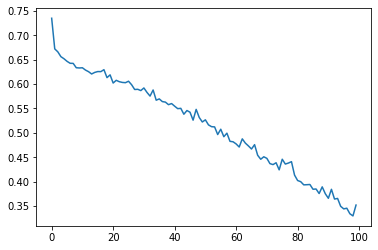

Epoch 1/100
66/66 - 4s - loss: 0.6998 - accuracy: 0.5680 - auc_25: 0.5896 - precision_25: 0.5712 - recall_25: 0.5765 - f1_score: 0.6707 - val_loss: 0.7296 - val_accuracy: 0.5064 - val_auc_25: 0.5416 - val_precision_25: 0.5625 - val_recall_25: 0.1500 - val_f1_score: 0.6761 - 4s/epoch - 61ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6756 - accuracy: 0.5803 - auc_25: 0.6087 - precision_25: 0.5775 - recall_25: 0.6263 - f1_score: 0.6707 - val_loss: 0.6959 - val_accuracy: 0.5191 - val_auc_25: 0.5618 - val_precision_25: 0.5259 - val_recall_25: 0.5917 - val_f1_score: 0.6761 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6635 - accuracy: 0.6097 - auc_25: 0.6418 - precision_25: 0.6089 - recall_25: 0.6329 - f1_score: 0.6707 - val_loss: 0.6972 - val_accuracy: 0.5660 - val_auc_25: 0.5570 - val_precision_25: 0.5714 - val_recall_25: 0.6000 - val_f1_score: 0.6761 - 1s/epoch - 16ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6607 - accuracy: 0.6149 - auc_25: 0.6466 - precision_25: 0.6117 - recall_25: 0.

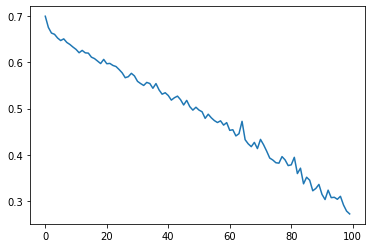

Epoch 1/100
66/66 - 4s - loss: 0.7215 - accuracy: 0.5396 - auc_26: 0.5536 - precision_26: 0.5440 - recall_26: 0.5450 - f1_score: 0.6711 - val_loss: 0.6759 - val_accuracy: 0.5872 - val_auc_26: 0.6227 - val_precision_26: 0.5679 - val_recall_26: 0.7731 - val_f1_score: 0.6723 - 4s/epoch - 61ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6738 - accuracy: 0.5931 - auc_26: 0.6152 - precision_26: 0.5937 - recall_26: 0.6154 - f1_score: 0.6711 - val_loss: 0.6663 - val_accuracy: 0.5745 - val_auc_26: 0.6403 - val_precision_26: 0.5979 - val_recall_26: 0.4874 - val_f1_score: 0.6723 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6644 - accuracy: 0.5936 - auc_26: 0.6365 - precision_26: 0.5959 - recall_26: 0.6060 - f1_score: 0.6711 - val_loss: 0.6724 - val_accuracy: 0.5957 - val_auc_26: 0.6328 - val_precision_26: 0.5769 - val_recall_26: 0.7563 - val_f1_score: 0.6723 - 1s/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6551 - accuracy: 0.6130 - auc_26: 0.6572 - precision_26: 0.6127 - recall_26: 0.

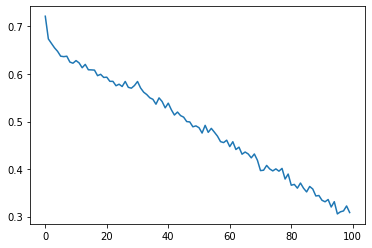

Epoch 1/100
66/66 - 4s - loss: 0.7201 - accuracy: 0.5658 - auc_27: 0.5666 - precision_27: 0.5629 - recall_27: 0.6038 - f1_score: 0.6683 - val_loss: 0.6745 - val_accuracy: 0.5299 - val_auc_27: 0.6777 - val_precision_27: 0.6531 - val_recall_27: 0.2560 - val_f1_score: 0.6964 - 4s/epoch - 59ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6670 - accuracy: 0.5914 - auc_27: 0.6303 - precision_27: 0.5863 - recall_27: 0.6311 - f1_score: 0.6683 - val_loss: 0.6750 - val_accuracy: 0.6026 - val_auc_27: 0.6120 - val_precision_27: 0.6231 - val_recall_27: 0.6480 - val_f1_score: 0.6964 - 982ms/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6734 - accuracy: 0.5720 - auc_27: 0.6112 - precision_27: 0.5690 - recall_27: 0.6066 - f1_score: 0.6683 - val_loss: 0.6512 - val_accuracy: 0.6496 - val_auc_27: 0.6910 - val_precision_27: 0.6569 - val_recall_27: 0.7200 - val_f1_score: 0.6964 - 1s/epoch - 16ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6571 - accuracy: 0.6241 - auc_27: 0.6540 - precision_27: 0.6137 - recall_27:

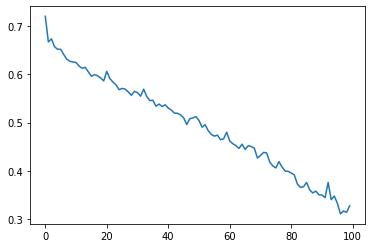

Epoch 1/100
66/66 - 4s - loss: 0.7175 - accuracy: 0.5549 - auc_28: 0.5574 - precision_28: 0.5566 - recall_28: 0.6411 - f1_score: 0.6771 - val_loss: 0.6848 - val_accuracy: 0.5641 - val_auc_28: 0.6035 - val_precision_28: 0.5081 - val_recall_28: 0.6058 - val_f1_score: 0.6154 - 4s/epoch - 57ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6758 - accuracy: 0.5909 - auc_28: 0.6117 - precision_28: 0.5951 - recall_28: 0.6281 - f1_score: 0.6771 - val_loss: 0.6847 - val_accuracy: 0.5598 - val_auc_28: 0.5592 - val_precision_28: 0.5062 - val_recall_28: 0.3942 - val_f1_score: 0.6154 - 1s/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6677 - accuracy: 0.6009 - auc_28: 0.6282 - precision_28: 0.6092 - recall_28: 0.6142 - f1_score: 0.6771 - val_loss: 0.6645 - val_accuracy: 0.5940 - val_auc_28: 0.6296 - val_precision_28: 0.5378 - val_recall_28: 0.6154 - val_f1_score: 0.6154 - 1s/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6687 - accuracy: 0.5999 - auc_28: 0.6285 - precision_28: 0.6030 - recall_28: 0.

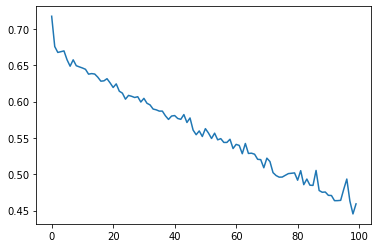

Epoch 1/100
66/66 - 4s - loss: 0.6994 - accuracy: 0.5668 - auc_29: 0.5902 - precision_29: 0.5659 - recall_29: 0.6047 - f1_score: 0.6704 - val_loss: 0.6877 - val_accuracy: 0.5684 - val_auc_29: 0.5820 - val_precision_29: 0.5482 - val_recall_29: 0.9000 - val_f1_score: 0.6780 - 4s/epoch - 61ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6717 - accuracy: 0.5881 - auc_29: 0.6107 - precision_29: 0.5758 - recall_29: 0.6958 - f1_score: 0.6704 - val_loss: 0.6672 - val_accuracy: 0.5812 - val_auc_29: 0.6291 - val_precision_29: 0.5753 - val_recall_29: 0.7000 - val_f1_score: 0.6780 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6556 - accuracy: 0.6113 - auc_29: 0.6473 - precision_29: 0.5995 - recall_29: 0.6901 - f1_score: 0.6704 - val_loss: 0.6727 - val_accuracy: 0.5855 - val_auc_29: 0.6481 - val_precision_29: 0.6667 - val_recall_29: 0.3833 - val_f1_score: 0.6780 - 964ms/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6421 - accuracy: 0.6288 - auc_29: 0.6696 - precision_29: 0.6162 - recall_29:

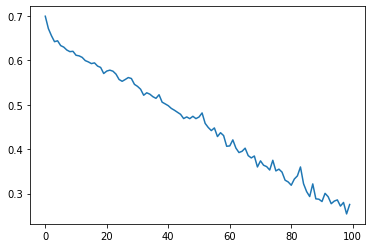

Epoch 1/100
66/66 - 4s - loss: 0.7352 - accuracy: 0.5308 - auc_30: 0.5348 - precision_30: 0.5314 - recall_30: 0.5289 - f1_score: 0.6671 - val_loss: 0.6959 - val_accuracy: 0.4786 - val_auc_30: 0.5678 - val_precision_30: 0.5750 - val_recall_30: 0.1797 - val_f1_score: 0.7072 - 4s/epoch - 56ms/step
Epoch 2/100
66/66 - 1s - loss: 0.6840 - accuracy: 0.5573 - auc_30: 0.5786 - precision_30: 0.5559 - recall_30: 0.5743 - f1_score: 0.6671 - val_loss: 0.6698 - val_accuracy: 0.5940 - val_auc_30: 0.6319 - val_precision_30: 0.6093 - val_recall_30: 0.7188 - val_f1_score: 0.7072 - 1s/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.6746 - accuracy: 0.5904 - auc_30: 0.6123 - precision_30: 0.5892 - recall_30: 0.5998 - f1_score: 0.6671 - val_loss: 0.6608 - val_accuracy: 0.6282 - val_auc_30: 0.6666 - val_precision_30: 0.6395 - val_recall_30: 0.7344 - val_f1_score: 0.7072 - 1s/epoch - 16ms/step
Epoch 4/100
66/66 - 1s - loss: 0.6753 - accuracy: 0.5781 - auc_30: 0.6088 - precision_30: 0.5741 - recall_30: 0.

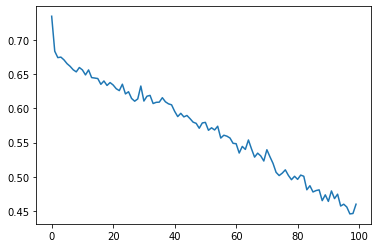

In [24]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        cnnlstm_binary_face_model.save(model_path / 'face_binary_cnnlstm.h5')

In [25]:
cnnlstm_binary_face_model = load_model(model_path / 'face_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 9ms/step - loss: 1.4738 - accuracy: 0.5000 - auc_21: 0.5849 - precision_21: 0.8673 - recall_21: 0.4851 - f1_score: 0.9182
Accuracy: 50.00% 
ROC/AUC: 0.58 
Precision: 0.87 
Recall: 0.49 
F1 score: 0.92


### RCNN

In [26]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(256, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
85/85 - 2s - loss: 2.2374 - accuracy: 0.5282 - auc_31: 0.5430 - precision_31: 0.5330 - recall_31: 0.5519 - f1_score: 0.6684 - val_loss: 1.6263 - val_accuracy: 0.5021 - val_auc_31: 0.5197 - val_precision_31: 0.4979 - val_recall_31: 1.0000 - val_f1_score: 0.6629 - 2s/epoch - 27ms/step
Epoch 2/100
85/85 - 1s - loss: 1.0787 - accuracy: 0.5424 - auc_31: 0.5639 - precision_31: 0.5486 - recall_31: 0.5435 - f1_score: 0.6749 - val_loss: 0.9283 - val_accuracy: 0.5191 - val_auc_31: 0.5496 - val_precision_31: 0.5069 - val_recall_31: 0.9483 - val_f1_score: 0.6628 - 1s/epoch - 13ms/step
Epoch 3/100
85/85 - 1s - loss: 1.1344 - accuracy: 0.5339 - auc_31: 0.5662 - precision_31: 0.5387 - recall_31: 0.5538 - f1_score: 0.6745 - val_loss: 1.1377 - val_accuracy: 0.5021 - val_auc_31: 0.5084 - val_precision_31: 0.4000 - val_recall_31: 0.0172 - val_f1_score: 0.6629 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.3534 - accuracy: 0.5476 - auc_31: 0.5663 - precision_31: 0.5550 - recall_31: 0.

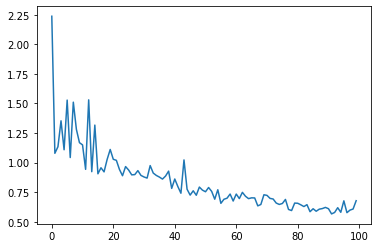

Epoch 1/100
85/85 - 3s - loss: 1.9530 - accuracy: 0.5216 - auc_32: 0.5348 - precision_32: 0.5259 - recall_32: 0.5594 - f1_score: 0.6705 - val_loss: 0.6730 - val_accuracy: 0.5064 - val_auc_32: 0.5414 - val_precision_32: 0.5000 - val_recall_32: 1.0000 - val_f1_score: 0.6629 - 3s/epoch - 31ms/step
Epoch 2/100
85/85 - 1s - loss: 1.3230 - accuracy: 0.5339 - auc_32: 0.5514 - precision_32: 0.5407 - recall_32: 0.5285 - f1_score: 0.6740 - val_loss: 0.7628 - val_accuracy: 0.5149 - val_auc_32: 0.5415 - val_precision_32: 0.7500 - val_recall_32: 0.0259 - val_f1_score: 0.6648 - 1s/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.6634 - accuracy: 0.5234 - auc_32: 0.5402 - precision_32: 0.5275 - recall_32: 0.5650 - f1_score: 0.6745 - val_loss: 0.7804 - val_accuracy: 0.5191 - val_auc_32: 0.5581 - val_precision_32: 0.8000 - val_recall_32: 0.0345 - val_f1_score: 0.6648 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.0545 - accuracy: 0.5476 - auc_32: 0.5841 - precision_32: 0.5521 - recall_32: 0.

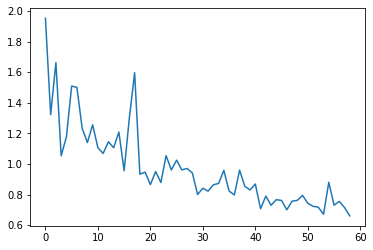

Epoch 1/100
85/85 - 2s - loss: 1.8628 - accuracy: 0.4998 - auc_33: 0.5099 - precision_33: 0.5038 - recall_33: 0.5038 - f1_score: 0.6696 - val_loss: 1.2077 - val_accuracy: 0.4894 - val_auc_33: 0.5022 - val_precision_33: 1.0000 - val_recall_33: 0.0083 - val_f1_score: 0.6818 - 2s/epoch - 26ms/step
Epoch 2/100
85/85 - 1s - loss: 1.2857 - accuracy: 0.5500 - auc_33: 0.5612 - precision_33: 0.5500 - recall_33: 0.5893 - f1_score: 0.6732 - val_loss: 0.7997 - val_accuracy: 0.4936 - val_auc_33: 0.5134 - val_precision_33: 1.0000 - val_recall_33: 0.0165 - val_f1_score: 0.6817 - 1s/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.4812 - accuracy: 0.5523 - auc_33: 0.5709 - precision_33: 0.5512 - recall_33: 0.6024 - f1_score: 0.6726 - val_loss: 1.4889 - val_accuracy: 0.4936 - val_auc_33: 0.5129 - val_precision_33: 1.0000 - val_recall_33: 0.0165 - val_f1_score: 0.6781 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.3260 - accuracy: 0.5647 - auc_33: 0.5934 - precision_33: 0.5716 - recall_33: 0.

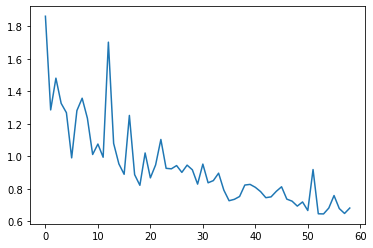

Epoch 1/100
85/85 - 2s - loss: 2.0140 - accuracy: 0.5021 - auc_34: 0.5092 - precision_34: 0.5081 - recall_34: 0.5285 - f1_score: 0.6703 - val_loss: 0.7346 - val_accuracy: 0.5064 - val_auc_34: 0.4809 - val_precision_34: 0.5000 - val_recall_34: 0.0172 - val_f1_score: 0.6648 - 2s/epoch - 27ms/step
Epoch 2/100
85/85 - 1s - loss: 1.1014 - accuracy: 0.5367 - auc_34: 0.5674 - precision_34: 0.5497 - recall_34: 0.4705 - f1_score: 0.6751 - val_loss: 1.0478 - val_accuracy: 0.5106 - val_auc_34: 0.5159 - val_precision_34: 0.5455 - val_recall_34: 0.0517 - val_f1_score: 0.6629 - 881ms/epoch - 10ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3298 - accuracy: 0.5457 - auc_34: 0.5716 - precision_34: 0.5525 - recall_34: 0.5416 - f1_score: 0.6745 - val_loss: 1.3274 - val_accuracy: 0.5021 - val_auc_34: 0.5014 - val_precision_34: 0.4000 - val_recall_34: 0.0172 - val_f1_score: 0.6629 - 971ms/epoch - 11ms/step
Epoch 4/100
85/85 - 1s - loss: 1.2074 - accuracy: 0.5689 - auc_34: 0.5998 - precision_34: 0.5661 - recall_

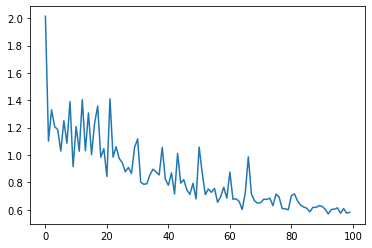

Epoch 1/100
85/85 - 2s - loss: 1.8678 - accuracy: 0.5234 - auc_35: 0.5406 - precision_35: 0.5262 - recall_35: 0.5568 - f1_score: 0.6682 - val_loss: 0.8691 - val_accuracy: 0.5064 - val_auc_35: 0.4898 - val_precision_35: 0.5087 - val_recall_35: 0.9750 - val_f1_score: 0.6761 - 2s/epoch - 28ms/step
Epoch 2/100
85/85 - 1s - loss: 1.8050 - accuracy: 0.5296 - auc_35: 0.5495 - precision_35: 0.5325 - recall_35: 0.5540 - f1_score: 0.6717 - val_loss: 1.4873 - val_accuracy: 0.4979 - val_auc_35: 0.5197 - val_precision_35: 1.0000 - val_recall_35: 0.0167 - val_f1_score: 0.6742 - 999ms/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3559 - accuracy: 0.5367 - auc_35: 0.5514 - precision_35: 0.5393 - recall_35: 0.5606 - f1_score: 0.6726 - val_loss: 0.8699 - val_accuracy: 0.5149 - val_auc_35: 0.5341 - val_precision_35: 0.5129 - val_recall_35: 0.9917 - val_f1_score: 0.6742 - 986ms/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.2565 - accuracy: 0.5324 - auc_35: 0.5466 - precision_35: 0.5322 - recall_

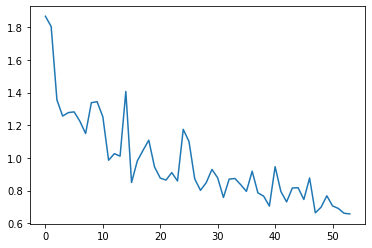

Epoch 1/100
85/85 - 2s - loss: 1.7498 - accuracy: 0.5410 - auc_36: 0.5484 - precision_36: 0.5460 - recall_36: 0.5403 - f1_score: 0.6692 - val_loss: 0.9371 - val_accuracy: 0.5064 - val_auc_36: 0.5194 - val_precision_36: 0.8000 - val_recall_36: 0.0336 - val_f1_score: 0.6723 - 2s/epoch - 27ms/step
Epoch 2/100
85/85 - 1s - loss: 1.4406 - accuracy: 0.5400 - auc_36: 0.5561 - precision_36: 0.5439 - recall_36: 0.5525 - f1_score: 0.6728 - val_loss: 0.7088 - val_accuracy: 0.5106 - val_auc_36: 0.5298 - val_precision_36: 1.0000 - val_recall_36: 0.0336 - val_f1_score: 0.6723 - 995ms/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3447 - accuracy: 0.5452 - auc_36: 0.5626 - precision_36: 0.5536 - recall_36: 0.5131 - f1_score: 0.6721 - val_loss: 0.6921 - val_accuracy: 0.5064 - val_auc_36: 0.5430 - val_precision_36: 0.8000 - val_recall_36: 0.0336 - val_f1_score: 0.6723 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.3394 - accuracy: 0.5514 - auc_36: 0.5793 - precision_36: 0.5492 - recall_36:

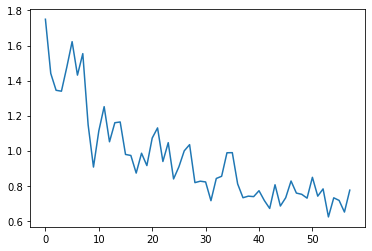

Epoch 1/100
85/85 - 2s - loss: 1.5145 - accuracy: 0.5241 - auc_37: 0.5322 - precision_37: 0.5265 - recall_37: 0.5160 - f1_score: 0.6700 - val_loss: 1.0008 - val_accuracy: 0.5385 - val_auc_37: 0.5191 - val_precision_37: 0.5365 - val_recall_37: 1.0000 - val_f1_score: 0.6983 - 2s/epoch - 27ms/step
Epoch 2/100
85/85 - 1s - loss: 1.3303 - accuracy: 0.5459 - auc_37: 0.5567 - precision_37: 0.5490 - recall_37: 0.5340 - f1_score: 0.6703 - val_loss: 0.8507 - val_accuracy: 0.5427 - val_auc_37: 0.4883 - val_precision_37: 0.5388 - val_recall_37: 1.0000 - val_f1_score: 0.6983 - 1s/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3739 - accuracy: 0.5360 - auc_37: 0.5553 - precision_37: 0.5380 - recall_37: 0.5340 - f1_score: 0.6705 - val_loss: 0.8458 - val_accuracy: 0.5427 - val_auc_37: 0.5068 - val_precision_37: 0.5388 - val_recall_37: 1.0000 - val_f1_score: 0.6983 - 1s/epoch - 13ms/step
Epoch 4/100
85/85 - 1s - loss: 1.0316 - accuracy: 0.5573 - auc_37: 0.5933 - precision_37: 0.5596 - recall_37: 0.

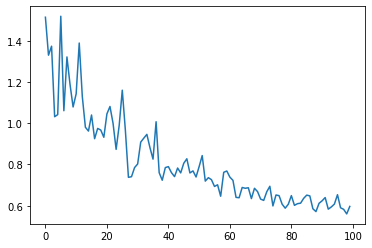

Epoch 1/100
85/85 - 2s - loss: 1.5306 - accuracy: 0.5085 - auc_38: 0.5119 - precision_38: 0.5224 - recall_38: 0.4635 - f1_score: 0.6784 - val_loss: 1.0865 - val_accuracy: 0.5641 - val_auc_38: 0.5326 - val_precision_38: 0.7500 - val_recall_38: 0.0288 - val_f1_score: 0.6154 - 2s/epoch - 26ms/step
Epoch 2/100
85/85 - 1s - loss: 1.5215 - accuracy: 0.5336 - auc_38: 0.5406 - precision_38: 0.5477 - recall_38: 0.5097 - f1_score: 0.6787 - val_loss: 0.7689 - val_accuracy: 0.5641 - val_auc_38: 0.5108 - val_precision_38: 0.7500 - val_recall_38: 0.0288 - val_f1_score: 0.6154 - 1s/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.0202 - accuracy: 0.5455 - auc_38: 0.5726 - precision_38: 0.5484 - recall_38: 0.6337 - f1_score: 0.6803 - val_loss: 0.7953 - val_accuracy: 0.4444 - val_auc_38: 0.5086 - val_precision_38: 0.4440 - val_recall_38: 0.9904 - val_f1_score: 0.6154 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.2428 - accuracy: 0.5535 - auc_38: 0.5727 - precision_38: 0.5624 - recall_38: 0.

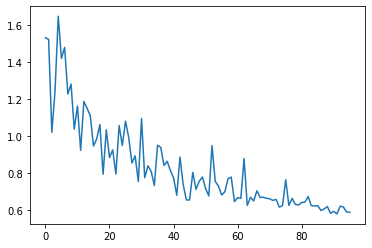

Epoch 1/100
85/85 - 2s - loss: 1.8445 - accuracy: 0.5071 - auc_39: 0.5132 - precision_39: 0.5124 - recall_39: 0.4657 - f1_score: 0.6675 - val_loss: 0.6934 - val_accuracy: 0.5171 - val_auc_39: 0.5034 - val_precision_39: 0.5150 - val_recall_39: 1.0000 - val_f1_score: 0.6780 - 2s/epoch - 26ms/step
Epoch 2/100
85/85 - 1s - loss: 1.6992 - accuracy: 0.5284 - auc_39: 0.5415 - precision_39: 0.5310 - recall_39: 0.5549 - f1_score: 0.6726 - val_loss: 1.1557 - val_accuracy: 0.4872 - val_auc_39: 0.4737 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.6724 - 1s/epoch - 13ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3796 - accuracy: 0.5388 - auc_39: 0.5669 - precision_39: 0.5514 - recall_39: 0.4582 - f1_score: 0.6728 - val_loss: 0.6790 - val_accuracy: 0.5043 - val_auc_39: 0.4957 - val_precision_39: 1.0000 - val_recall_39: 0.0333 - val_f1_score: 0.6799 - 1s/epoch - 12ms/step
Epoch 4/100
85/85 - 1s - loss: 1.6327 - accuracy: 0.5275 - auc_39: 0.5427 - precision_39: 0.5352 - recal

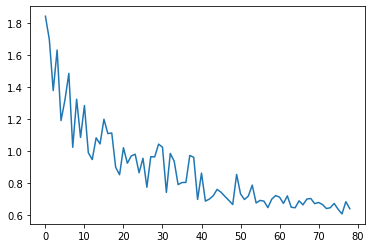

Epoch 1/100
85/85 - 2s - loss: 2.0640 - accuracy: 0.5066 - auc_40: 0.5165 - precision_40: 0.5068 - recall_40: 0.5326 - f1_score: 0.6690 - val_loss: 0.7728 - val_accuracy: 0.4573 - val_auc_40: 0.4593 - val_precision_40: 0.6667 - val_recall_40: 0.0156 - val_f1_score: 0.7091 - 2s/epoch - 28ms/step
Epoch 2/100
85/85 - 1s - loss: 1.2796 - accuracy: 0.5284 - auc_40: 0.5506 - precision_40: 0.5302 - recall_40: 0.5071 - f1_score: 0.6692 - val_loss: 0.8301 - val_accuracy: 0.4060 - val_auc_40: 0.4971 - val_precision_40: 0.3721 - val_recall_40: 0.1250 - val_f1_score: 0.7111 - 1s/epoch - 12ms/step
Epoch 3/100
85/85 - 1s - loss: 1.3079 - accuracy: 0.5483 - auc_40: 0.5574 - precision_40: 0.5409 - recall_40: 0.6443 - f1_score: 0.6698 - val_loss: 0.6846 - val_accuracy: 0.5556 - val_auc_40: 0.5475 - val_precision_40: 0.5517 - val_recall_40: 1.0000 - val_f1_score: 0.7091 - 1s/epoch - 14ms/step
Epoch 4/100
85/85 - 1s - loss: 1.0896 - accuracy: 0.5554 - auc_40: 0.5880 - precision_40: 0.5617 - recall_40: 0.

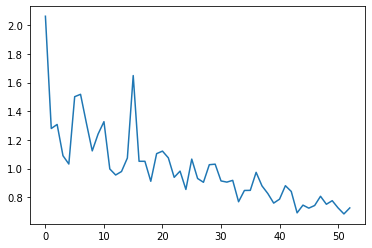

In [27]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=25)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        rcnn_binary_face_model.save(model_path / 'face_binary_rcnn.h5')

In [28]:
rcnn_binary_face_model = load_model(model_path / 'face_binary_rcnn.h5')
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 0.8486 - accuracy: 0.1975 - auc_37: 0.5329 - precision_37: 1.0000 - recall_37: 0.0545 - f1_score: 0.9182
Accuracy: 19.75% 
ROC/AUC: 0.53 
Precision: 1.00 
Recall: 0.05 
F1 score: 0.92


## 3. Multimodal Early Fusion

### Apply Data Augmentation

In [29]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 60) (782, 1)
(238, 1, 350, 60) (238, 1)


In [30]:
jitter_X = jitter(X, sigma=0.03)

In [31]:
reshaped_X = X.reshape((X.shape[0], X.shape[2], X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [32]:
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((y, y), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(2346, 1, 350, 60)

### CNN + BiLSTM

In [33]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='tanh'))(flatten)
        dense = Dense(128, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
85/85 - 5s - loss: 0.7106 - accuracy: 0.5471 - auc_41: 0.5491 - precision_41: 0.5514 - recall_41: 0.5669 - f1_score: 0.6723 - val_loss: 0.6720 - val_accuracy: 0.5872 - val_auc_41: 0.6309 - val_precision_41: 0.6000 - val_recall_41: 0.4914 - val_f1_score: 0.6610 - 5s/epoch - 60ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6801 - accuracy: 0.5737 - auc_41: 0.5980 - precision_41: 0.5776 - recall_41: 0.5884 - f1_score: 0.6723 - val_loss: 0.6886 - val_accuracy: 0.5574 - val_auc_41: 0.5938 - val_precision_41: 0.5423 - val_recall_41: 0.6638 - val_f1_score: 0.6610 - 2s/epoch - 19ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6690 - accuracy: 0.5983 - auc_41: 0.6276 - precision_41: 0.5974 - recall_41: 0.6342 - f1_score: 0.6723 - val_loss: 0.7108 - val_accuracy: 0.5617 - val_auc_41: 0.6243 - val_precision_41: 0.6857 - val_recall_41: 0.2069 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6453 - accuracy: 0.6272 - auc_41: 0.6745 - precision_41: 0.6348 - recall_41: 0.

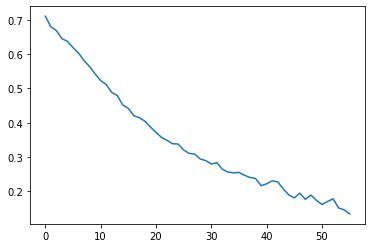

Epoch 1/100
85/85 - 5s - loss: 0.7224 - accuracy: 0.5268 - auc_42: 0.5292 - precision_42: 0.5310 - recall_42: 0.5603 - f1_score: 0.6723 - val_loss: 0.6947 - val_accuracy: 0.5404 - val_auc_42: 0.5545 - val_precision_42: 0.5267 - val_recall_42: 0.6810 - val_f1_score: 0.6610 - 5s/epoch - 62ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6774 - accuracy: 0.5803 - auc_42: 0.6051 - precision_42: 0.5830 - recall_42: 0.6015 - f1_score: 0.6723 - val_loss: 0.6896 - val_accuracy: 0.5489 - val_auc_42: 0.5689 - val_precision_42: 0.5368 - val_recall_42: 0.6293 - val_f1_score: 0.6610 - 2s/epoch - 19ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6622 - accuracy: 0.6206 - auc_42: 0.6478 - precision_42: 0.6201 - recall_42: 0.6473 - f1_score: 0.6723 - val_loss: 0.7156 - val_accuracy: 0.5277 - val_auc_42: 0.6058 - val_precision_42: 0.5150 - val_recall_42: 0.7414 - val_f1_score: 0.6610 - 2s/epoch - 19ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6478 - accuracy: 0.6158 - auc_42: 0.6675 - precision_42: 0.6219 - recall_42: 0.

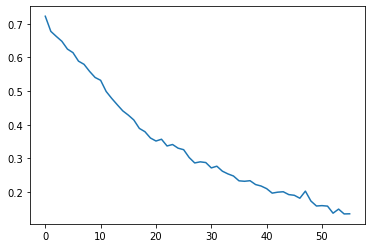

Epoch 1/100
85/85 - 5s - loss: 0.7137 - accuracy: 0.5358 - auc_43: 0.5414 - precision_43: 0.5349 - recall_43: 0.6053 - f1_score: 0.6702 - val_loss: 0.6714 - val_accuracy: 0.5830 - val_auc_43: 0.6259 - val_precision_43: 0.5891 - val_recall_43: 0.6281 - val_f1_score: 0.6798 - 5s/epoch - 59ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6770 - accuracy: 0.5950 - auc_43: 0.6067 - precision_43: 0.5934 - recall_43: 0.6241 - f1_score: 0.6702 - val_loss: 0.6995 - val_accuracy: 0.5106 - val_auc_43: 0.5684 - val_precision_43: 0.5188 - val_recall_43: 0.6860 - val_f1_score: 0.6798 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6694 - accuracy: 0.5926 - auc_43: 0.6272 - precision_43: 0.5926 - recall_43: 0.6137 - f1_score: 0.6702 - val_loss: 0.6499 - val_accuracy: 0.6000 - val_auc_43: 0.6768 - val_precision_43: 0.6047 - val_recall_43: 0.6446 - val_f1_score: 0.6798 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6552 - accuracy: 0.6158 - auc_43: 0.6559 - precision_43: 0.6172 - recall_43: 0.

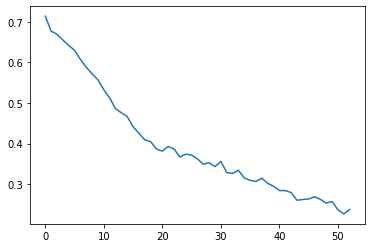

Epoch 1/100
85/85 - 5s - loss: 0.7120 - accuracy: 0.5329 - auc_44: 0.5394 - precision_44: 0.5375 - recall_44: 0.5566 - f1_score: 0.6723 - val_loss: 0.6908 - val_accuracy: 0.5447 - val_auc_44: 0.6467 - val_precision_44: 0.5238 - val_recall_44: 0.8534 - val_f1_score: 0.6610 - 5s/epoch - 62ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6824 - accuracy: 0.5580 - auc_44: 0.5867 - precision_44: 0.5561 - recall_44: 0.6305 - f1_score: 0.6723 - val_loss: 0.6880 - val_accuracy: 0.5574 - val_auc_44: 0.6064 - val_precision_44: 0.5882 - val_recall_44: 0.3448 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6679 - accuracy: 0.6021 - auc_44: 0.6261 - precision_44: 0.6121 - recall_44: 0.5847 - f1_score: 0.6723 - val_loss: 0.6640 - val_accuracy: 0.5915 - val_auc_44: 0.6456 - val_precision_44: 0.5794 - val_recall_44: 0.6293 - val_f1_score: 0.6610 - 2s/epoch - 19ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6551 - accuracy: 0.6172 - auc_44: 0.6527 - precision_44: 0.6291 - recall_44: 0.

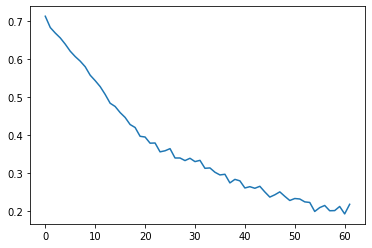

Epoch 1/100
85/85 - 5s - loss: 0.7078 - accuracy: 0.5310 - auc_45: 0.5523 - precision_45: 0.5344 - recall_45: 0.5465 - f1_score: 0.6707 - val_loss: 0.6915 - val_accuracy: 0.5319 - val_auc_45: 0.5711 - val_precision_45: 0.5321 - val_recall_45: 0.6917 - val_f1_score: 0.6761 - 5s/epoch - 57ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6781 - accuracy: 0.5784 - auc_45: 0.6047 - precision_45: 0.5819 - recall_45: 0.5840 - f1_score: 0.6707 - val_loss: 0.6781 - val_accuracy: 0.5702 - val_auc_45: 0.5987 - val_precision_45: 0.5638 - val_recall_45: 0.7000 - val_f1_score: 0.6761 - 2s/epoch - 19ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6687 - accuracy: 0.5964 - auc_45: 0.6264 - precision_45: 0.5950 - recall_45: 0.6263 - f1_score: 0.6707 - val_loss: 0.6873 - val_accuracy: 0.6000 - val_auc_45: 0.5993 - val_precision_45: 0.6327 - val_recall_45: 0.5167 - val_f1_score: 0.6761 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6493 - accuracy: 0.6234 - auc_45: 0.6671 - precision_45: 0.6216 - recall_45: 0.

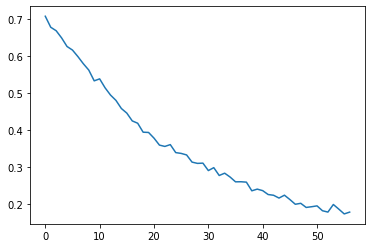

Epoch 1/100
85/85 - 5s - loss: 0.7148 - accuracy: 0.5433 - auc_46: 0.5581 - precision_46: 0.5458 - recall_46: 0.5704 - f1_score: 0.6711 - val_loss: 0.6934 - val_accuracy: 0.5064 - val_auc_46: 0.5966 - val_precision_46: 0.5273 - val_recall_46: 0.2437 - val_f1_score: 0.6723 - 5s/epoch - 61ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6700 - accuracy: 0.5983 - auc_46: 0.6250 - precision_46: 0.6075 - recall_46: 0.5779 - f1_score: 0.6711 - val_loss: 0.6695 - val_accuracy: 0.6085 - val_auc_46: 0.6343 - val_precision_46: 0.6800 - val_recall_46: 0.4286 - val_f1_score: 0.6723 - 2s/epoch - 18ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6561 - accuracy: 0.6116 - auc_46: 0.6552 - precision_46: 0.6165 - recall_46: 0.6107 - f1_score: 0.6711 - val_loss: 0.7117 - val_accuracy: 0.5149 - val_auc_46: 0.6011 - val_precision_46: 0.5150 - val_recall_46: 0.7227 - val_f1_score: 0.6723 - 2s/epoch - 18ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6337 - accuracy: 0.6485 - auc_46: 0.6946 - precision_46: 0.6511 - recall_46: 0.

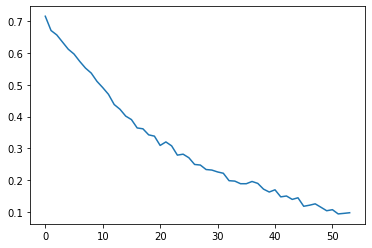

Epoch 1/100
85/85 - 5s - loss: 0.7091 - accuracy: 0.5440 - auc_47: 0.5636 - precision_47: 0.5457 - recall_47: 0.5462 - f1_score: 0.6683 - val_loss: 0.6617 - val_accuracy: 0.5812 - val_auc_47: 0.6542 - val_precision_47: 0.6627 - val_recall_47: 0.4400 - val_f1_score: 0.6964 - 5s/epoch - 56ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6738 - accuracy: 0.6023 - auc_47: 0.6183 - precision_47: 0.6116 - recall_47: 0.5689 - f1_score: 0.6683 - val_loss: 0.6579 - val_accuracy: 0.6282 - val_auc_47: 0.6543 - val_precision_47: 0.6377 - val_recall_47: 0.7040 - val_f1_score: 0.6964 - 2s/epoch - 18ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6627 - accuracy: 0.6174 - auc_47: 0.6422 - precision_47: 0.6221 - recall_47: 0.6057 - f1_score: 0.6683 - val_loss: 0.6624 - val_accuracy: 0.6026 - val_auc_47: 0.6424 - val_precision_47: 0.6053 - val_recall_47: 0.7360 - val_f1_score: 0.6964 - 2s/epoch - 18ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6467 - accuracy: 0.6387 - auc_47: 0.6752 - precision_47: 0.6405 - recall_47: 0.

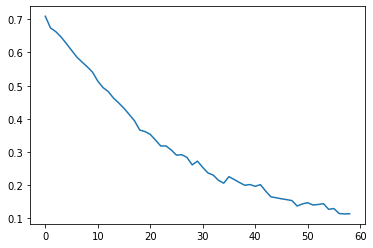

Epoch 1/100
85/85 - 5s - loss: 0.7075 - accuracy: 0.5521 - auc_48: 0.5525 - precision_48: 0.5509 - recall_48: 0.6753 - f1_score: 0.6771 - val_loss: 0.7132 - val_accuracy: 0.4701 - val_auc_48: 0.5964 - val_precision_48: 0.4438 - val_recall_48: 0.7596 - val_f1_score: 0.6154 - 5s/epoch - 59ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6753 - accuracy: 0.5772 - auc_48: 0.6114 - precision_48: 0.5845 - recall_48: 0.6013 - f1_score: 0.6771 - val_loss: 0.6836 - val_accuracy: 0.5470 - val_auc_48: 0.5966 - val_precision_48: 0.4737 - val_recall_48: 0.1731 - val_f1_score: 0.6154 - 2s/epoch - 18ms/step
Epoch 3/100
85/85 - 1s - loss: 0.6528 - accuracy: 0.6165 - auc_48: 0.6602 - precision_48: 0.6222 - recall_48: 0.6383 - f1_score: 0.6771 - val_loss: 0.6941 - val_accuracy: 0.5641 - val_auc_48: 0.6026 - val_precision_48: 0.5294 - val_recall_48: 0.1731 - val_f1_score: 0.6154 - 1s/epoch - 17ms/step
Epoch 4/100
85/85 - 1s - loss: 0.6345 - accuracy: 0.6406 - auc_48: 0.6942 - precision_48: 0.6453 - recall_48: 0.

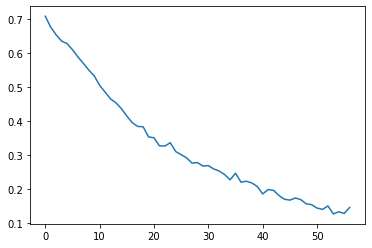

Epoch 1/100
85/85 - 5s - loss: 0.7108 - accuracy: 0.5275 - auc_49: 0.5448 - precision_49: 0.5308 - recall_49: 0.5418 - f1_score: 0.6704 - val_loss: 0.6955 - val_accuracy: 0.5385 - val_auc_49: 0.5644 - val_precision_49: 0.6364 - val_recall_49: 0.2333 - val_f1_score: 0.6780 - 5s/epoch - 56ms/step
Epoch 2/100
85/85 - 1s - loss: 0.6896 - accuracy: 0.5554 - auc_49: 0.5752 - precision_49: 0.5582 - recall_49: 0.5671 - f1_score: 0.6704 - val_loss: 0.7051 - val_accuracy: 0.5598 - val_auc_49: 0.5883 - val_precision_49: 0.6604 - val_recall_49: 0.2917 - val_f1_score: 0.6780 - 1s/epoch - 18ms/step
Epoch 3/100
85/85 - 1s - loss: 0.6713 - accuracy: 0.5933 - auc_49: 0.6236 - precision_49: 0.5961 - recall_49: 0.6000 - f1_score: 0.6704 - val_loss: 0.6862 - val_accuracy: 0.6111 - val_auc_49: 0.5841 - val_precision_49: 0.6283 - val_recall_49: 0.5917 - val_f1_score: 0.6780 - 1s/epoch - 18ms/step
Epoch 4/100
85/85 - 2s - loss: 0.6572 - accuracy: 0.6174 - auc_49: 0.6529 - precision_49: 0.6169 - recall_49: 0.

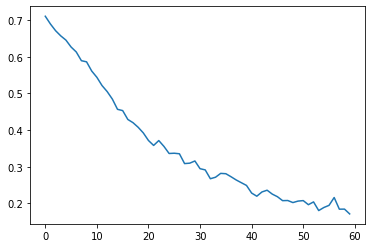

Epoch 1/100
85/85 - 5s - loss: 0.7216 - accuracy: 0.5294 - auc_50: 0.5406 - precision_50: 0.5322 - recall_50: 0.4920 - f1_score: 0.6671 - val_loss: 0.6963 - val_accuracy: 0.5342 - val_auc_50: 0.5952 - val_precision_50: 0.6377 - val_recall_50: 0.3438 - val_f1_score: 0.7072 - 5s/epoch - 59ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6835 - accuracy: 0.5611 - auc_50: 0.5819 - precision_50: 0.5565 - recall_50: 0.6055 - f1_score: 0.6671 - val_loss: 0.6584 - val_accuracy: 0.5726 - val_auc_50: 0.6552 - val_precision_50: 0.5897 - val_recall_50: 0.7188 - val_f1_score: 0.7072 - 2s/epoch - 18ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6757 - accuracy: 0.5805 - auc_50: 0.6127 - precision_50: 0.5849 - recall_50: 0.5572 - f1_score: 0.6671 - val_loss: 0.6411 - val_accuracy: 0.6068 - val_auc_50: 0.6822 - val_precision_50: 0.6084 - val_recall_50: 0.7891 - val_f1_score: 0.7072 - 2s/epoch - 18ms/step
Epoch 4/100
85/85 - 1s - loss: 0.6658 - accuracy: 0.6080 - auc_50: 0.6355 - precision_50: 0.6021 - recall_50: 0.

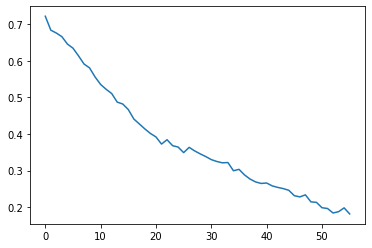

In [34]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_binary_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs, 25)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        cnnlstm_binary_earlyfusion_model.save(model_path / 'early_binary_cnnlstm.h5')

In [35]:
cnnlstm_binary_earlyfusion_model = load_model(model_path / 'early_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_earlyfusion_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 10ms/step - loss: 0.6699 - accuracy: 0.6261 - auc_46: 0.7270 - precision_46: 0.9380 - recall_46: 0.5990 - f1_score: 0.9182
Accuracy: 62.61% 
ROC/AUC: 0.73 
Precision: 0.94 
Recall: 0.60 
F1 score: 0.92


### RCNN

In [36]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(128, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
66/66 - 2s - loss: 1.2254 - accuracy: 0.5287 - auc_51: 0.5397 - precision_51: 0.5321 - recall_51: 0.5744 - f1_score: 0.6705 - val_loss: 1.0626 - val_accuracy: 0.5021 - val_auc_51: 0.5125 - val_precision_51: 0.4000 - val_recall_51: 0.0172 - val_f1_score: 0.6610 - 2s/epoch - 34ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9856 - accuracy: 0.5263 - auc_51: 0.5398 - precision_51: 0.5276 - recall_51: 0.6165 - f1_score: 0.6730 - val_loss: 1.0916 - val_accuracy: 0.4979 - val_auc_51: 0.5084 - val_precision_51: 0.3333 - val_recall_51: 0.0172 - val_f1_score: 0.6610 - 861ms/epoch - 13ms/step
Epoch 3/100
66/66 - 1s - loss: 1.0680 - accuracy: 0.5405 - auc_51: 0.5485 - precision_51: 0.5450 - recall_51: 0.5613 - f1_score: 0.6723 - val_loss: 0.7272 - val_accuracy: 0.5021 - val_auc_51: 0.5042 - val_precision_51: 0.3333 - val_recall_51: 0.0086 - val_f1_score: 0.6610 - 927ms/epoch - 14ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9819 - accuracy: 0.5296 - auc_51: 0.5551 - precision_51: 0.5308 - recall_

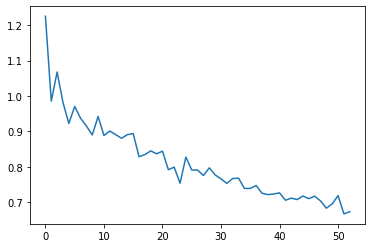

Epoch 1/100
66/66 - 2s - loss: 1.3500 - accuracy: 0.5244 - auc_52: 0.5234 - precision_52: 0.5257 - recall_52: 0.6221 - f1_score: 0.6713 - val_loss: 0.8686 - val_accuracy: 0.5149 - val_auc_52: 0.5094 - val_precision_52: 1.0000 - val_recall_52: 0.0172 - val_f1_score: 0.6610 - 2s/epoch - 34ms/step
Epoch 2/100
66/66 - 1s - loss: 1.0629 - accuracy: 0.5197 - auc_52: 0.5287 - precision_52: 0.5215 - recall_52: 0.6249 - f1_score: 0.6730 - val_loss: 0.7918 - val_accuracy: 0.5191 - val_auc_52: 0.5159 - val_precision_52: 1.0000 - val_recall_52: 0.0259 - val_f1_score: 0.6629 - 894ms/epoch - 14ms/step
Epoch 3/100
66/66 - 1s - loss: 1.0752 - accuracy: 0.5386 - auc_52: 0.5529 - precision_52: 0.5373 - recall_52: 0.6399 - f1_score: 0.6730 - val_loss: 0.6919 - val_accuracy: 0.5234 - val_auc_52: 0.4946 - val_precision_52: 1.0000 - val_recall_52: 0.0345 - val_f1_score: 0.6610 - 911ms/epoch - 14ms/step
Epoch 4/100
66/66 - 1s - loss: 1.0739 - accuracy: 0.5448 - auc_52: 0.5606 - precision_52: 0.5514 - recall_

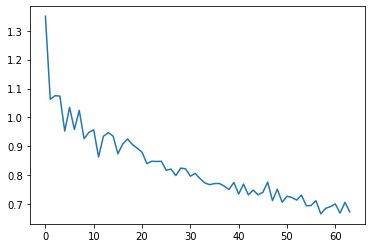

Epoch 1/100
66/66 - 3s - loss: 1.2214 - accuracy: 0.4898 - auc_53: 0.4910 - precision_53: 0.4925 - recall_53: 0.4013 - f1_score: 0.6702 - val_loss: 0.7559 - val_accuracy: 0.4936 - val_auc_53: 0.5180 - val_precision_53: 0.7500 - val_recall_53: 0.0248 - val_f1_score: 0.6798 - 3s/epoch - 41ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9935 - accuracy: 0.5197 - auc_53: 0.5337 - precision_53: 0.5210 - recall_53: 0.5818 - f1_score: 0.6700 - val_loss: 0.7679 - val_accuracy: 0.4936 - val_auc_53: 0.5377 - val_precision_53: 0.7500 - val_recall_53: 0.0248 - val_f1_score: 0.6798 - 1s/epoch - 16ms/step
Epoch 3/100
66/66 - 1s - loss: 1.0018 - accuracy: 0.5301 - auc_53: 0.5414 - precision_53: 0.5367 - recall_53: 0.4944 - f1_score: 0.6702 - val_loss: 0.9941 - val_accuracy: 0.4936 - val_auc_53: 0.5405 - val_precision_53: 1.0000 - val_recall_53: 0.0165 - val_f1_score: 0.6723 - 995ms/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.8960 - accuracy: 0.5495 - auc_53: 0.5761 - precision_53: 0.5513 - recall_53:

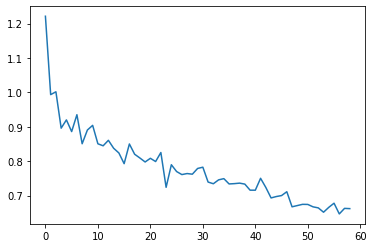

Epoch 1/100
66/66 - 2s - loss: 1.2580 - accuracy: 0.5135 - auc_54: 0.5181 - precision_54: 0.5211 - recall_54: 0.4846 - f1_score: 0.6725 - val_loss: 0.8000 - val_accuracy: 0.5021 - val_auc_54: 0.5007 - val_precision_54: 0.4000 - val_recall_54: 0.0172 - val_f1_score: 0.6610 - 2s/epoch - 37ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9572 - accuracy: 0.5448 - auc_54: 0.5545 - precision_54: 0.5535 - recall_54: 0.5229 - f1_score: 0.6723 - val_loss: 0.9787 - val_accuracy: 0.5021 - val_auc_54: 0.5043 - val_precision_54: 0.4000 - val_recall_54: 0.0172 - val_f1_score: 0.6610 - 1s/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 1.0167 - accuracy: 0.5306 - auc_54: 0.5440 - precision_54: 0.5350 - recall_54: 0.5575 - f1_score: 0.6723 - val_loss: 0.9264 - val_accuracy: 0.4979 - val_auc_54: 0.4593 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.6610 - 984ms/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9224 - accuracy: 0.5306 - auc_54: 0.5543 - precision_54: 0.5416 - re

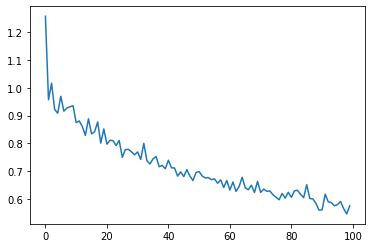

Epoch 1/100
66/66 - 2s - loss: 1.3748 - accuracy: 0.5092 - auc_55: 0.5245 - precision_55: 0.5132 - recall_55: 0.5286 - f1_score: 0.6702 - val_loss: 0.7725 - val_accuracy: 0.4979 - val_auc_55: 0.5184 - val_precision_55: 0.6667 - val_recall_55: 0.0333 - val_f1_score: 0.6761 - 2s/epoch - 37ms/step
Epoch 2/100
66/66 - 1s - loss: 1.0843 - accuracy: 0.5358 - auc_55: 0.5511 - precision_55: 0.5431 - recall_55: 0.5033 - f1_score: 0.6711 - val_loss: 0.7901 - val_accuracy: 0.4979 - val_auc_55: 0.5309 - val_precision_55: 0.6667 - val_recall_55: 0.0333 - val_f1_score: 0.6761 - 977ms/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9830 - accuracy: 0.5329 - auc_55: 0.5517 - precision_55: 0.5421 - recall_55: 0.4779 - f1_score: 0.6707 - val_loss: 0.7117 - val_accuracy: 0.5191 - val_auc_55: 0.5513 - val_precision_55: 0.5150 - val_recall_55: 1.0000 - val_f1_score: 0.6761 - 989ms/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9257 - accuracy: 0.5329 - auc_55: 0.5485 - precision_55: 0.5331 - recall_

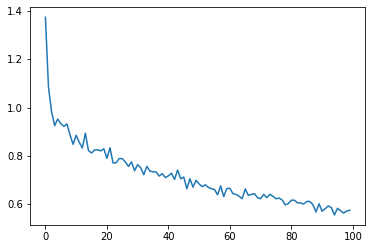

Epoch 1/100
66/66 - 2s - loss: 1.1915 - accuracy: 0.5197 - auc_56: 0.5227 - precision_56: 0.5240 - recall_56: 0.5328 - f1_score: 0.6711 - val_loss: 0.8503 - val_accuracy: 0.4936 - val_auc_56: 0.4825 - val_precision_56: 0.5000 - val_recall_56: 0.0084 - val_f1_score: 0.6686 - 2s/epoch - 36ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9670 - accuracy: 0.5197 - auc_56: 0.5399 - precision_56: 0.5217 - recall_56: 0.5872 - f1_score: 0.6723 - val_loss: 0.8870 - val_accuracy: 0.4936 - val_auc_56: 0.5368 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.6686 - 942ms/epoch - 14ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9384 - accuracy: 0.5315 - auc_56: 0.5577 - precision_56: 0.5384 - recall_56: 0.5066 - f1_score: 0.6713 - val_loss: 0.7383 - val_accuracy: 0.4936 - val_auc_56: 0.5199 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.6723 - 875ms/epoch - 13ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9543 - accuracy: 0.5405 - auc_56: 0.5602 - precision_56: 

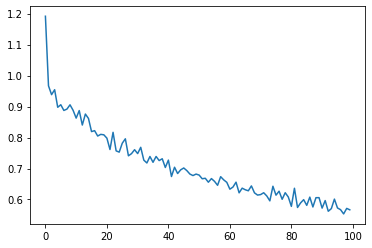

Epoch 1/100
66/66 - 2s - loss: 1.1760 - accuracy: 0.4967 - auc_57: 0.5019 - precision_57: 0.4988 - recall_57: 0.5745 - f1_score: 0.6677 - val_loss: 0.9041 - val_accuracy: 0.6154 - val_auc_57: 0.5234 - val_precision_57: 0.6129 - val_recall_57: 0.7600 - val_f1_score: 0.6964 - 2s/epoch - 34ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9672 - accuracy: 0.5270 - auc_57: 0.5345 - precision_57: 0.5329 - recall_57: 0.4660 - f1_score: 0.6688 - val_loss: 0.8491 - val_accuracy: 0.4615 - val_auc_57: 0.5271 - val_precision_57: 0.3333 - val_recall_57: 0.0080 - val_f1_score: 0.6964 - 955ms/epoch - 14ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9150 - accuracy: 0.5393 - auc_57: 0.5717 - precision_57: 0.5436 - recall_57: 0.5113 - f1_score: 0.6694 - val_loss: 1.0124 - val_accuracy: 0.4615 - val_auc_57: 0.5292 - val_precision_57: 0.3333 - val_recall_57: 0.0080 - val_f1_score: 0.6964 - 920ms/epoch - 14ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9408 - accuracy: 0.5398 - auc_57: 0.5567 - precision_57: 0.5384 - recall_

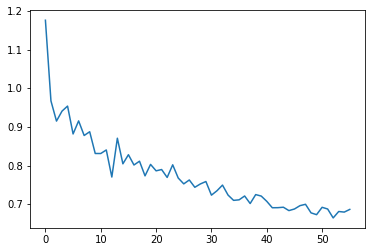

Epoch 1/100
66/66 - 2s - loss: 1.3594 - accuracy: 0.4962 - auc_58: 0.5024 - precision_58: 0.5103 - recall_58: 0.3895 - f1_score: 0.6761 - val_loss: 0.9081 - val_accuracy: 0.5641 - val_auc_58: 0.4841 - val_precision_58: 0.7500 - val_recall_58: 0.0288 - val_f1_score: 0.6154 - 2s/epoch - 34ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9825 - accuracy: 0.5327 - auc_58: 0.5534 - precision_58: 0.5407 - recall_58: 0.5782 - f1_score: 0.6780 - val_loss: 0.7894 - val_accuracy: 0.5598 - val_auc_58: 0.5648 - val_precision_58: 0.6667 - val_recall_58: 0.0192 - val_f1_score: 0.6154 - 967ms/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9578 - accuracy: 0.5459 - auc_58: 0.5736 - precision_58: 0.5479 - recall_58: 0.6457 - f1_score: 0.6790 - val_loss: 0.8003 - val_accuracy: 0.5598 - val_auc_58: 0.4808 - val_precision_58: 0.6667 - val_recall_58: 0.0192 - val_f1_score: 0.6154 - 954ms/epoch - 14ms/step
Epoch 4/100
66/66 - 1s - loss: 0.9544 - accuracy: 0.5483 - auc_58: 0.5580 - precision_58: 0.5653 - recall_

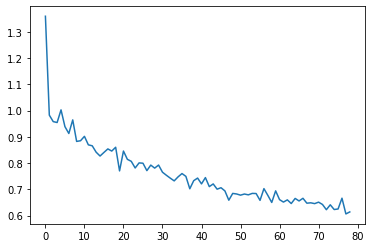

Epoch 1/100
66/66 - 2s - loss: 1.2721 - accuracy: 0.5355 - auc_59: 0.5351 - precision_59: 0.5452 - recall_59: 0.4761 - f1_score: 0.6713 - val_loss: 0.6836 - val_accuracy: 0.5128 - val_auc_59: 0.5020 - val_precision_59: 0.5129 - val_recall_59: 0.9917 - val_f1_score: 0.6780 - 2s/epoch - 32ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9561 - accuracy: 0.5265 - auc_59: 0.5470 - precision_59: 0.5280 - recall_59: 0.5746 - f1_score: 0.6715 - val_loss: 0.9833 - val_accuracy: 0.4915 - val_auc_59: 0.4963 - val_precision_59: 1.0000 - val_recall_59: 0.0083 - val_f1_score: 0.6742 - 977ms/epoch - 15ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9991 - accuracy: 0.5502 - auc_59: 0.5600 - precision_59: 0.5554 - recall_59: 0.5408 - f1_score: 0.6711 - val_loss: 0.8183 - val_accuracy: 0.5043 - val_auc_59: 0.4996 - val_precision_59: 0.5086 - val_recall_59: 0.9833 - val_f1_score: 0.6780 - 942ms/epoch - 14ms/step
Epoch 4/100
66/66 - 1s - loss: 1.0012 - accuracy: 0.5402 - auc_59: 0.5613 - precision_59: 0.5434 - recall_

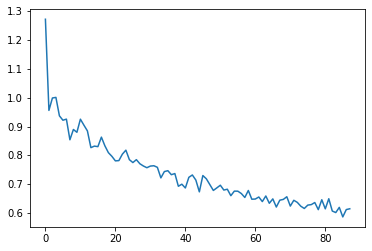

Epoch 1/100
66/66 - 2s - loss: 1.2907 - accuracy: 0.5227 - auc_60: 0.5330 - precision_60: 0.5245 - recall_60: 0.4957 - f1_score: 0.6671 - val_loss: 0.8353 - val_accuracy: 0.4402 - val_auc_60: 0.4916 - val_precision_60: 0.4776 - val_recall_60: 0.2500 - val_f1_score: 0.7072 - 2s/epoch - 34ms/step
Epoch 2/100
66/66 - 1s - loss: 0.9431 - accuracy: 0.5355 - auc_60: 0.5528 - precision_60: 0.5268 - recall_60: 0.7067 - f1_score: 0.6679 - val_loss: 1.0090 - val_accuracy: 0.5470 - val_auc_60: 0.5223 - val_precision_60: 0.5474 - val_recall_60: 0.9922 - val_f1_score: 0.7036 - 954ms/epoch - 14ms/step
Epoch 3/100
66/66 - 1s - loss: 0.9626 - accuracy: 0.5355 - auc_60: 0.5583 - precision_60: 0.5372 - recall_60: 0.5194 - f1_score: 0.6671 - val_loss: 0.8154 - val_accuracy: 0.4573 - val_auc_60: 0.5042 - val_precision_60: 1.0000 - val_recall_60: 0.0078 - val_f1_score: 0.7072 - 960ms/epoch - 15ms/step
Epoch 4/100
66/66 - 1s - loss: 0.8928 - accuracy: 0.5497 - auc_60: 0.5741 - precision_60: 0.5542 - recall_

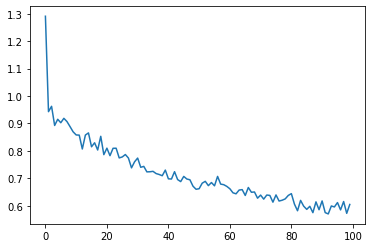

In [37]:
acc = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_binary_earlyfusion_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        rcnn_binary_earlyfusion_model.save(model_path / 'early_binary_rcnn.h5')

In [38]:
rcnn_binary_earlyfusion_model = load_model(model_path / 'early_binary_rcnn.h5')
y_pred = rcnn_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_earlyfusion_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 0.7457 - accuracy: 0.8109 - auc_55: 0.5017 - precision_55: 0.8458 - recall_55: 0.9505 - f1_score: 0.9182
Accuracy: 81.09% 
ROC/AUC: 0.50 
Precision: 0.85 
Recall: 0.95 
F1 score: 0.92


## 3. Multimodal Late Fusion

### Apply Data Augmentation

In [39]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 1)
(238, 1, 350, 35) (238, 1)


In [40]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [41]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

In [42]:
jitter_X = jitter(body_X, sigma=0.03)

In [43]:
reshaped_X = body_X.reshape((body_X.shape[0], body_X.shape[2], body_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [44]:
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((y, y), axis=0)
body_X = np.concatenate((augmented_X, body_X), axis=0)
y = np.concatenate((add_y, y), axis=0) 
body_X.shape

(2346, 1, 350, 35)

In [45]:
jitter_X = jitter(face_X, sigma=0.03)

In [46]:
reshaped_X = face_X.reshape((face_X.shape[0], face_X.shape[2], face_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [47]:
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
face_X = np.concatenate((augmented_X, face_X), axis=0)
face_X.shape

(2346, 1, 350, 25)

### CNN + BiLSTM

In [48]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(300)(flatten_1)
        dense_1 = Dense(64, activation='tanh')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(300)(flatten_2)
        dense_2 = Dense(64, activation='tanh')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def save(self, model_path):
        self.model.save(model_path)

Epoch 1/100
85/85 - 5s - loss: 0.7439 - accuracy: 0.5324 - auc_61: 0.5377 - precision_61: 0.5373 - recall_61: 0.5529 - f1_score: 0.6723 - val_loss: 0.7216 - val_accuracy: 0.4936 - val_auc_61: 0.6124 - val_precision_61: 0.4348 - val_recall_61: 0.0862 - val_f1_score: 0.6610 - 5s/epoch - 62ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6608 - accuracy: 0.6087 - auc_61: 0.6431 - precision_61: 0.6128 - recall_61: 0.6174 - f1_score: 0.6723 - val_loss: 0.7024 - val_accuracy: 0.5915 - val_auc_61: 0.6101 - val_precision_61: 0.5758 - val_recall_61: 0.6552 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6247 - accuracy: 0.6551 - auc_61: 0.7054 - precision_61: 0.6549 - recall_61: 0.6745 - f1_score: 0.6723 - val_loss: 0.6958 - val_accuracy: 0.5574 - val_auc_61: 0.6396 - val_precision_61: 0.5357 - val_recall_61: 0.7759 - val_f1_score: 0.6610 - 2s/epoch - 21ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5821 - accuracy: 0.6845 - auc_61: 0.7568 - precision_61: 0.6824 - recall_61: 0.

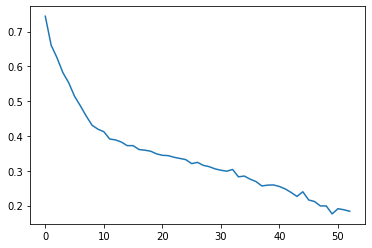

Epoch 1/100
85/85 - 5s - loss: 0.7316 - accuracy: 0.5495 - auc_62: 0.5488 - precision_62: 0.5501 - recall_62: 0.6062 - f1_score: 0.6723 - val_loss: 0.7097 - val_accuracy: 0.5532 - val_auc_62: 0.5536 - val_precision_62: 0.5325 - val_recall_62: 0.7759 - val_f1_score: 0.6610 - 5s/epoch - 60ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6549 - accuracy: 0.6210 - auc_62: 0.6591 - precision_62: 0.6200 - recall_62: 0.6501 - f1_score: 0.6723 - val_loss: 0.6838 - val_accuracy: 0.5660 - val_auc_62: 0.6094 - val_precision_62: 0.5660 - val_recall_62: 0.5172 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6012 - accuracy: 0.6840 - auc_62: 0.7380 - precision_62: 0.6858 - recall_62: 0.6941 - f1_score: 0.6723 - val_loss: 0.7428 - val_accuracy: 0.5021 - val_auc_62: 0.6429 - val_precision_62: 0.4878 - val_recall_62: 0.1724 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5570 - accuracy: 0.7148 - auc_62: 0.7892 - precision_62: 0.7140 - recall_62: 0.

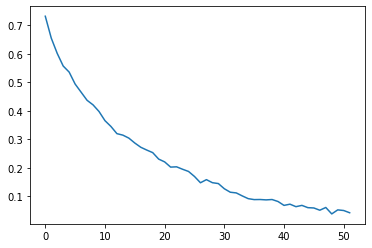

Epoch 1/100
85/85 - 5s - loss: 0.7328 - accuracy: 0.5414 - auc_63: 0.5469 - precision_63: 0.5444 - recall_63: 0.5526 - f1_score: 0.6702 - val_loss: 0.6790 - val_accuracy: 0.5745 - val_auc_63: 0.6408 - val_precision_63: 0.6180 - val_recall_63: 0.4545 - val_f1_score: 0.6798 - 5s/epoch - 62ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6561 - accuracy: 0.6101 - auc_63: 0.6511 - precision_63: 0.6089 - recall_63: 0.6335 - f1_score: 0.6702 - val_loss: 0.6394 - val_accuracy: 0.6128 - val_auc_63: 0.6819 - val_precision_63: 0.6190 - val_recall_63: 0.6446 - val_f1_score: 0.6798 - 2s/epoch - 21ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6200 - accuracy: 0.6528 - auc_63: 0.7112 - precision_63: 0.6520 - recall_63: 0.6673 - f1_score: 0.6702 - val_loss: 0.6728 - val_accuracy: 0.5957 - val_auc_63: 0.6458 - val_precision_63: 0.6275 - val_recall_63: 0.5289 - val_f1_score: 0.6798 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5722 - accuracy: 0.6987 - auc_63: 0.7709 - precision_63: 0.6993 - recall_63: 0.

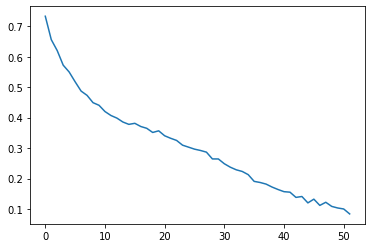

Epoch 1/100
85/85 - 5s - loss: 0.7529 - accuracy: 0.5135 - auc_64: 0.5142 - precision_64: 0.5186 - recall_64: 0.5482 - f1_score: 0.6723 - val_loss: 0.6898 - val_accuracy: 0.5702 - val_auc_64: 0.6021 - val_precision_64: 0.5758 - val_recall_64: 0.4914 - val_f1_score: 0.6610 - 5s/epoch - 60ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6757 - accuracy: 0.5727 - auc_64: 0.6103 - precision_64: 0.5719 - recall_64: 0.6211 - f1_score: 0.6723 - val_loss: 0.6915 - val_accuracy: 0.5617 - val_auc_64: 0.5978 - val_precision_64: 0.5371 - val_recall_64: 0.8103 - val_f1_score: 0.6610 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6273 - accuracy: 0.6433 - auc_64: 0.7016 - precision_64: 0.6353 - recall_64: 0.6941 - f1_score: 0.6723 - val_loss: 0.6810 - val_accuracy: 0.5915 - val_auc_64: 0.6171 - val_precision_64: 0.5862 - val_recall_64: 0.5862 - val_f1_score: 0.6610 - 2s/epoch - 21ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5917 - accuracy: 0.6788 - auc_64: 0.7472 - precision_64: 0.6729 - recall_64: 0.

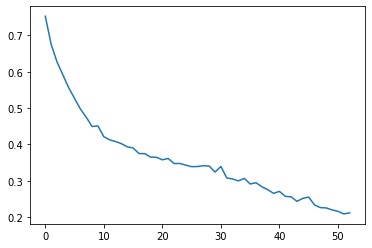

Epoch 1/100
85/85 - 5s - loss: 0.7275 - accuracy: 0.5419 - auc_65: 0.5638 - precision_65: 0.5461 - recall_65: 0.5455 - f1_score: 0.6707 - val_loss: 0.7271 - val_accuracy: 0.5149 - val_auc_65: 0.5604 - val_precision_65: 0.5167 - val_recall_65: 0.7750 - val_f1_score: 0.6761 - 5s/epoch - 62ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6532 - accuracy: 0.6158 - auc_65: 0.6606 - precision_65: 0.6187 - recall_65: 0.6216 - f1_score: 0.6707 - val_loss: 0.7677 - val_accuracy: 0.5319 - val_auc_65: 0.5802 - val_precision_65: 0.5253 - val_recall_65: 0.8667 - val_f1_score: 0.6761 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6122 - accuracy: 0.6660 - auc_65: 0.7236 - precision_65: 0.6667 - recall_65: 0.6761 - f1_score: 0.6707 - val_loss: 0.7393 - val_accuracy: 0.5277 - val_auc_65: 0.6112 - val_precision_65: 0.5236 - val_recall_65: 0.8333 - val_f1_score: 0.6761 - 2s/epoch - 19ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5903 - accuracy: 0.6916 - auc_65: 0.7512 - precision_65: 0.6892 - recall_65: 0.

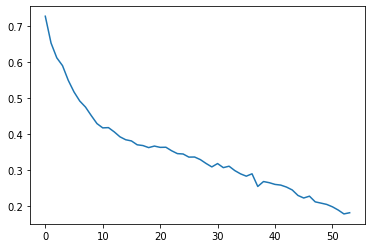

Epoch 1/100
85/85 - 5s - loss: 0.7268 - accuracy: 0.5448 - auc_66: 0.5608 - precision_66: 0.5455 - recall_66: 0.5901 - f1_score: 0.6711 - val_loss: 0.6917 - val_accuracy: 0.5362 - val_auc_66: 0.5711 - val_precision_66: 0.5309 - val_recall_66: 0.7227 - val_f1_score: 0.6723 - 5s/epoch - 60ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6508 - accuracy: 0.6082 - auc_66: 0.6625 - precision_66: 0.6112 - recall_66: 0.6163 - f1_score: 0.6711 - val_loss: 0.6870 - val_accuracy: 0.5702 - val_auc_66: 0.6280 - val_precision_66: 0.5849 - val_recall_66: 0.5210 - val_f1_score: 0.6723 - 2s/epoch - 21ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6133 - accuracy: 0.6561 - auc_66: 0.7198 - precision_66: 0.6562 - recall_66: 0.6698 - f1_score: 0.6711 - val_loss: 0.7124 - val_accuracy: 0.5532 - val_auc_66: 0.6323 - val_precision_66: 0.6061 - val_recall_66: 0.3361 - val_f1_score: 0.6723 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5755 - accuracy: 0.6930 - auc_66: 0.7662 - precision_66: 0.7002 - recall_66: 0.

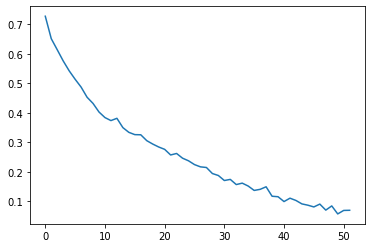

Epoch 1/100
85/85 - 5s - loss: 0.7156 - accuracy: 0.5341 - auc_67: 0.5528 - precision_67: 0.5366 - recall_67: 0.5255 - f1_score: 0.6683 - val_loss: 0.6851 - val_accuracy: 0.5598 - val_auc_67: 0.5943 - val_precision_67: 0.5948 - val_recall_67: 0.5520 - val_f1_score: 0.6964 - 5s/epoch - 64ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6607 - accuracy: 0.6065 - auc_67: 0.6505 - precision_67: 0.6053 - recall_67: 0.6208 - f1_score: 0.6683 - val_loss: 0.6842 - val_accuracy: 0.5726 - val_auc_67: 0.6214 - val_precision_67: 0.5683 - val_recall_67: 0.8320 - val_f1_score: 0.6964 - 2s/epoch - 21ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6223 - accuracy: 0.6548 - auc_67: 0.7098 - precision_67: 0.6572 - recall_67: 0.6528 - f1_score: 0.6683 - val_loss: 0.6713 - val_accuracy: 0.6667 - val_auc_67: 0.6608 - val_precision_67: 0.6343 - val_recall_67: 0.8880 - val_f1_score: 0.6964 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5935 - accuracy: 0.6832 - auc_67: 0.7457 - precision_67: 0.6809 - recall_67: 0.

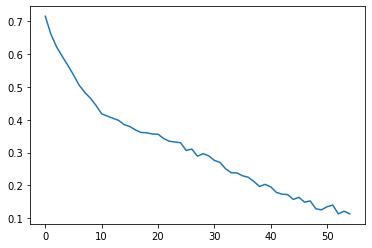

Epoch 1/100
85/85 - 5s - loss: 0.7483 - accuracy: 0.5080 - auc_68: 0.5159 - precision_68: 0.5185 - recall_68: 0.5458 - f1_score: 0.6771 - val_loss: 0.7513 - val_accuracy: 0.4145 - val_auc_68: 0.5325 - val_precision_68: 0.4260 - val_recall_68: 0.9135 - val_f1_score: 0.6154 - 5s/epoch - 59ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6743 - accuracy: 0.5838 - auc_68: 0.6090 - precision_68: 0.5899 - recall_68: 0.6133 - f1_score: 0.6771 - val_loss: 0.6779 - val_accuracy: 0.5726 - val_auc_68: 0.6215 - val_precision_68: 0.5161 - val_recall_68: 0.6154 - val_f1_score: 0.6154 - 2s/epoch - 21ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6302 - accuracy: 0.6506 - auc_68: 0.7001 - precision_68: 0.6544 - recall_68: 0.6725 - f1_score: 0.6771 - val_loss: 0.7694 - val_accuracy: 0.5684 - val_auc_68: 0.5940 - val_precision_68: 0.5306 - val_recall_68: 0.2500 - val_f1_score: 0.6154 - 2s/epoch - 19ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5985 - accuracy: 0.6761 - auc_68: 0.7416 - precision_68: 0.6780 - recall_68: 0.

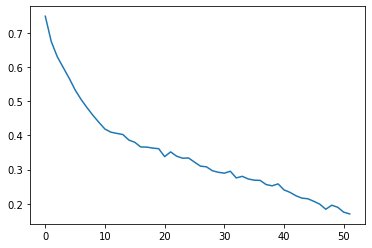

Epoch 1/100
85/85 - 5s - loss: 0.7454 - accuracy: 0.5365 - auc_69: 0.5418 - precision_69: 0.5399 - recall_69: 0.5465 - f1_score: 0.6704 - val_loss: 0.6976 - val_accuracy: 0.4872 - val_auc_69: 0.5810 - val_precision_69: 0.5000 - val_recall_69: 0.7583 - val_f1_score: 0.6780 - 5s/epoch - 63ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6645 - accuracy: 0.6080 - auc_69: 0.6332 - precision_69: 0.6074 - recall_69: 0.6291 - f1_score: 0.6704 - val_loss: 0.6675 - val_accuracy: 0.5983 - val_auc_69: 0.6383 - val_precision_69: 0.6161 - val_recall_69: 0.5750 - val_f1_score: 0.6780 - 2s/epoch - 21ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6290 - accuracy: 0.6411 - auc_69: 0.6949 - precision_69: 0.6397 - recall_69: 0.6601 - f1_score: 0.6704 - val_loss: 0.6590 - val_accuracy: 0.5812 - val_auc_69: 0.6729 - val_precision_69: 0.5696 - val_recall_69: 0.7500 - val_f1_score: 0.6780 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5913 - accuracy: 0.6771 - auc_69: 0.7474 - precision_69: 0.6705 - recall_69: 0.

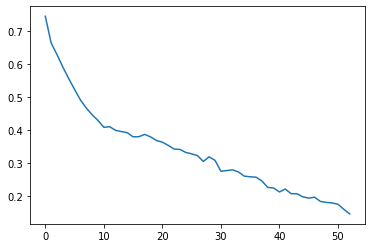

Epoch 1/100
85/85 - 5s - loss: 0.7320 - accuracy: 0.5459 - auc_70: 0.5520 - precision_70: 0.5468 - recall_70: 0.5412 - f1_score: 0.6671 - val_loss: 0.7744 - val_accuracy: 0.5214 - val_auc_70: 0.5977 - val_precision_70: 0.5440 - val_recall_70: 0.7734 - val_f1_score: 0.7072 - 5s/epoch - 59ms/step
Epoch 2/100
85/85 - 2s - loss: 0.6537 - accuracy: 0.6236 - auc_70: 0.6609 - precision_70: 0.6252 - recall_70: 0.6187 - f1_score: 0.6671 - val_loss: 0.6812 - val_accuracy: 0.5726 - val_auc_70: 0.6355 - val_precision_70: 0.5660 - val_recall_70: 0.9375 - val_f1_score: 0.7072 - 2s/epoch - 20ms/step
Epoch 3/100
85/85 - 2s - loss: 0.6059 - accuracy: 0.6723 - auc_70: 0.7346 - precision_70: 0.6698 - recall_70: 0.6812 - f1_score: 0.6671 - val_loss: 0.7248 - val_accuracy: 0.5769 - val_auc_70: 0.6299 - val_precision_70: 0.6261 - val_recall_70: 0.5625 - val_f1_score: 0.7072 - 2s/epoch - 20ms/step
Epoch 4/100
85/85 - 2s - loss: 0.5623 - accuracy: 0.7003 - auc_70: 0.7770 - precision_70: 0.6938 - recall_70: 0.

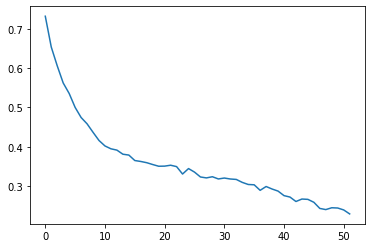

In [49]:
acc = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_latefusion_model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = cnnlstm_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=25)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        cnnlstm_binary_latefusion_model.save(model_path / 'late_binary_cnnlstm.h5')

In [50]:
cnnlstm_binary_latefusion_model = load_model(model_path / 'late_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_latefusion_model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_latefusion_model.evaluate(body_X_test, face_X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### RCNN

In [ ]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(64)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(64)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def save(self, model_path):
        self.model.save(model_path)

In [ ]:
acc = 0.0
for train_index, val_index in kf.split(X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_latefusion_model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = rcnn_binary_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    if history.history['accuracy'][-1] > acc:
        acc = history.history['accuracy'][-1]
        rcnn_binary_latefusion_model.save(model_path / 'late_binary_rcnn.h5')

Epoch 1/100
22/22 - 2s - loss: 2.7095 - accuracy: 0.4794 - auc_70: 0.4765 - precision_70: 0.4891 - recall_70: 0.5028 - f1_score: 0.6748 - val_loss: 5.8304 - val_accuracy: 0.5443 - val_auc_70: 0.4990 - val_precision_70: 0.5455 - val_recall_70: 0.1622 - val_f1_score: 0.6140 - 2s/epoch - 93ms/step
Epoch 2/100
22/22 - 0s - loss: 1.6200 - accuracy: 0.5107 - auc_70: 0.5153 - precision_70: 0.5199 - recall_70: 0.5112 - f1_score: 0.6749 - val_loss: 4.2382 - val_accuracy: 0.4430 - val_auc_70: 0.4427 - val_precision_70: 0.4478 - val_recall_70: 0.8108 - val_f1_score: 0.6140 - 426ms/epoch - 19ms/step
Epoch 3/100
22/22 - 0s - loss: 1.4774 - accuracy: 0.5349 - auc_70: 0.5595 - precision_70: 0.5427 - recall_70: 0.5503 - f1_score: 0.6748 - val_loss: 7.1462 - val_accuracy: 0.4557 - val_auc_70: 0.4961 - val_precision_70: 0.4615 - val_recall_70: 0.9730 - val_f1_score: 0.6261 - 412ms/epoch - 19ms/step
Epoch 4/100
22/22 - 0s - loss: 1.8257 - accuracy: 0.5235 - auc_70: 0.5195 - precision_70: 0.5310 - recall_

In [ ]:
rcnn_binary_latefusion_model = load_model(model_path / 'late_binary_rcnn.h5')
y_pred = rcnn_binary_latefusion_model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_latefusion_model.evaluate(body_X_test, face_X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 16.39% 
ROC/AUC: 0.57 
Precision: 1.00 
Recall: 0.01 
F1 score: 0.91


### Ensemble

In [ ]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [ ]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [ ]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.4252)
RCNN Body Model (weight: 0.4623)
CNN + Bidirectional LSTM Face Model (weight: 0.0027)
RCNN Face Model (weight: 0.1098)
Accuracy: 100.00% - ROC/AUC: 0.72 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


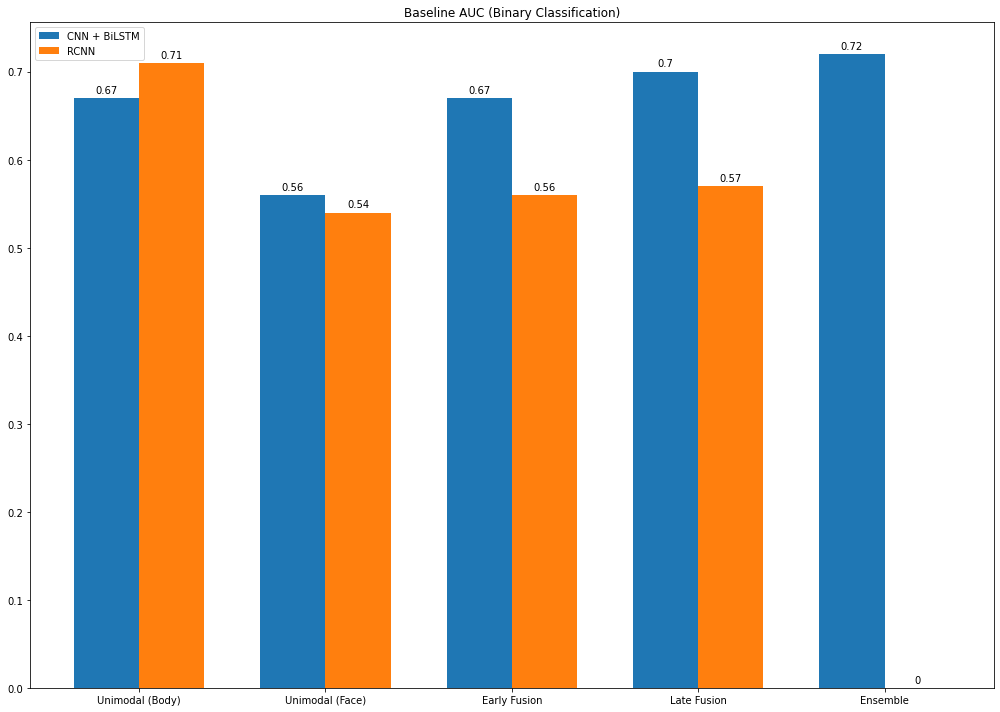

In [ ]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnn_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()